#Imports

In [1]:
!pip install scikeras
!pip install scikit-learn==1.5.1

In [54]:
import os
import random
import warnings
from typing import Tuple, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    cohen_kappa_score,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from scipy.stats import randint, uniform
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from sklearn.model_selection import (
    GroupKFold,
    GroupShuffleSplit,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
    StratifiedKFold,
    cross_validate
)

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)




In [6]:
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)

channel_names = ['AF3', 'AF4', 'F3', 'F4', 'F7','F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
N_INSTANCES = 112
N_CHANNELS = 14
FEATURES_PER_CHANNEL = 32
N_FEATURES = N_CHANNELS * FEATURES_PER_CHANNEL
METADATA_COLS = ['SUBJECT', 'GAME']

# Helper Functions

In [41]:
def print_per_fold_accuracy(cv_results: dict, model_name: str):
    """
    Prints the individual test accuracy score obtained for each cross-validation fold.

    Args:
        cv_results: The dictionary returned by sklearn.model_selection.cross_validate.
        model_name: Name of the classifier (e.g., 'SVM - AF3 Channel').
    """
    test_scores = cv_results.get('test_accuracy')

    if test_scores is None or len(test_scores) == 0:
        print(f"Error: No 'test_accuracy' scores found for {model_name}.")
        return

    print(f"\n--- Detailed Per-Fold Accuracy for {model_name} ---")

    # Iterate through the array of scores (one score per fold)
    for i, score in enumerate(test_scores):
        print(f"Fold {i+1}: {score:.4f}")

    # Also print the overall mean and standard deviation
    mean_score = np.mean(test_scores)
    std_score = np.std(test_scores)
    print("--------------------------------------------------")
    print(f"Mean Accuracy: {mean_score:.4f} (±{std_score:.4f})")
    print("--------------------------------------------------")


def print_cv_results(cv_results, model_name):
    print(f"## 🏆 Results for {model_name} (Multi-class with 10-Fold CV)")
    print("---")
    for key in ['test_accuracy', 'test_f1_score', 'test_precision', 'test_recall']:
        metric_name = key.replace('test_', '').replace('_w', '').capitalize()
        scores = cv_results.get(key, [np.nan])
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        print(f"**{metric_name}**: {mean_score:.4f} (±{std_score:.4f})")
    print("\n" + "="*50 + "\n")

def create_mlp_model(input_dim=N_FEATURES, output_dim=4, seed=SEED):
    """Creates the MLP model exactly as defined in the notebook (Cell 9)."""
    # Note: Keras uses Adam by default which is consistent with the notebook's setup,
    # despite the paper mentioning an SGD solver parameter for scikit-learn's wrapper.
    # We follow the Keras model definition which is more specific.
    tf.random.set_seed(seed)

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu', name='Hidden_1'),
        Dropout(0.3),
        Dense(64, activation='relu', name='Hidden_2'),
        Dropout(0.3),
        Dense(32, activation='relu', name='Hidden_3'),
        Dense(output_dim, activation='softmax', name='Output_Layer') # Softmax for multi-class
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy', # Used when y is integer-encoded (0, 1, 2...)
        metrics=['accuracy']
    )
    return model



### Helper Functions and Data Structures

In [55]:
class EEGSequenceDataset(Dataset):
    """
    Each item is a (sequence, label) pair.
    sequence: (seq_len, feature_dim) float32 tensor
    label: scalar long (class index)
    """
    def __init__(self, sequences, labels):
        assert len(sequences) == len(labels)
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x = torch.tensor(self.sequences[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y


def collate_fn(batch):
    """
    Collate variable-length sequences:
    - pad to max length in batch
    - return (padded_sequences, lengths, labels)
    """
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)

    padded_seqs = pad_sequence(
        sequences, batch_first=True  # shape: (batch, max_len, feat_dim)
    )
    labels = torch.tensor(labels, dtype=torch.long)
    return padded_seqs, lengths, labels


def build_sequences_from_csv(csv_path):
    """
    Load CSV and build sequences.

    Sequences: group by (SUBJECT, GAME), sorted by WINDOW_INDEX.
    Label for each sequence is GAME (class index).
    """
    df = pd.read_csv(csv_path)

    non_feature_cols = ["SUBJECT", "GAME", "WINDOW_INDEX"]
    feature_cols = [c for c in df.columns if c not in non_feature_cols]

    # force all features to be numeric
    df[feature_cols] = df[feature_cols].apply(
        pd.to_numeric, errors="coerce"
    )

    unique_games = sorted(df["GAME"].unique())
    game_to_idx = {g: i for i, g in enumerate(unique_games)}
    print(f"Found GAME labels: {unique_games}")
    print(f"GAME -> class index map: {game_to_idx}")

    sequences = []
    labels = []
    subjects = []

    df_sorted = df.sort_values(by=["SUBJECT", "GAME", "WINDOW_INDEX"])

    for (subject, game), group in df_sorted.groupby(["SUBJECT", "GAME"]):
        x_seq = group[feature_cols].to_numpy(dtype=np.float32)  # (seq_len, feat_dim)
        y = game_to_idx[game]
        sequences.append(x_seq)
        labels.append(y)
        subjects.append(subject)

    # sequences is left as a Python list of np.ndarrays
    labels = np.array(labels, dtype=np.int64)
    subjects = np.array(subjects, dtype=np.int64)

    return sequences, labels, subjects, len(feature_cols), len(unique_games), game_to_idx


def subject_level_split(subjects, train_ratio=0.7, val_ratio=0.15, seed=42):
    """
    Split indices by SUBJECT, so one subject's sequences
    never appear in multiple splits.
    """
    rng = random.Random(seed)
    unique_subjects = list(sorted(set(subjects)))
    rng.shuffle(unique_subjects)

    n_subj = len(unique_subjects)
    n_train = int(n_subj * train_ratio)
    n_val = int(n_subj * val_ratio)
    n_test = n_subj - n_train - n_val

    train_subjects = set(unique_subjects[:n_train])
    val_subjects = set(unique_subjects[n_train:n_train + n_val])
    test_subjects = set(unique_subjects[n_train + n_val:])

    train_idx, val_idx, test_idx = [], [], []

    for i, subj in enumerate(subjects):
        if subj in train_subjects:
            train_idx.append(i)
        elif subj in val_subjects:
            val_idx.append(i)
        else:
            test_idx.append(i)

    print(f"Subjects: total={n_subj}, train={len(train_subjects)}, "
          f"val={len(val_subjects)}, test={len(test_subjects)}")
    print(f"Sequences: total={len(subjects)}, "
          f"train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")

    return train_idx, val_idx, test_idx

def normalize_with_train_stats(sequences, train_indices):
    """
    Compute mean/std from training sequences only and normalize all sequences.
    Ensures everything is a proper float array (no object dtype).
    """
    # Force conversion to a numeric NumPy array
    train_data = np.concatenate(
        [np.asarray(sequences[i], dtype=np.float32) for i in train_indices],
        axis=0
    )

    mean = train_data.mean(axis=0, keepdims=True)
    std = train_data.std(axis=0, keepdims=True) + 1e-8  # avoid division by zero

    def norm(seq):
        seq_arr = np.asarray(seq, dtype=np.float32)
        return (seq_arr - mean) / std

    norm_sequences = [norm(seq) for seq in sequences]
    return norm_sequences, mean, std


# Exploratory Data Analysis

## SAM score verification

In [ ]:
import pandas as pd
import matplotlib as plt
import seaborn as sns

In [ ]:
# load the cleaned csv data
df = pd.read_csv('/content/final_SAM_scores_cleaned.csv')
display(df)

,Unnamed: 0,Path,Subject,Valence,Arousal,Gender,Age,Satisfaction,Boring,Horrible,Calm,Funny
0,0,G1.pdf,S01,2,3,Female,24,2,8,1,3,2
1,1,G2.pdf,S01,5,4,Female,24,7,2,1,8,8
2,2,G3.pdf,S01,2,9,Female,24,2,2,8,1,1
3,3,G4.pdf,S01,5,8,Female,24,8,1,1,3,9
4,4,G1.pdf,S02,1,1,Male,23,1,8,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...
107,107,G4.pdf,S27,5,4,Male,22,5,1,1,7,5
108,108,G1.pdf,S28,1,4,Male,24,2,7,1,6,1
109,109,G2.pdf,S28,8,2,Male,24,9,1,1,8,8
110,110,G3.pdf,S28,1,4,Male,24,3,1,7,6,1


In [ ]:
# create a sub_df for each group
groups = ['G1.pdf', 'G2.pdf', 'G3.pdf', 'G4.pdf']
sub_dfs = []
for group in groups:
    sub_df = df[df['Path'] == group]
    # sanity check - should be 28
    if(len(sub_df)!=28):
      raise ValueError(f"Group {group} has {len(sub_df)} rows, expected 28")
    sub_dfs.append(sub_df)
display(sub_dfs[3])

,Unnamed: 0,Path,Subject,Valence,Arousal,Gender,Age,Satisfaction,Boring,Horrible,Calm,Funny
3,3,G4.pdf,S01,5,8,Female,24,8,1,1,3,9
7,7,G4.pdf,S02,7,5,Male,23,8,2,2,7,9
11,11,G4.pdf,S03,9,6,Male,25,9,1,1,3,9
15,15,G4.pdf,S04,6,7,Male,20,8,1,1,3,9
19,19,G4.pdf,S05,9,7,Female,25,7,2,1,3,8
23,23,G4.pdf,S06,7,7,Female,21,7,1,1,8,8
27,27,G4.pdf,S07,9,9,Male,22,8,1,1,1,10
31,31,G4.pdf,S08,5,6,Male,26,8,1,1,6,6
35,35,G4.pdf,S09,5,1,Male,23,8,1,1,8,8
39,39,G4.pdf,S10,9,5,Male,20,8,1,1,5,10


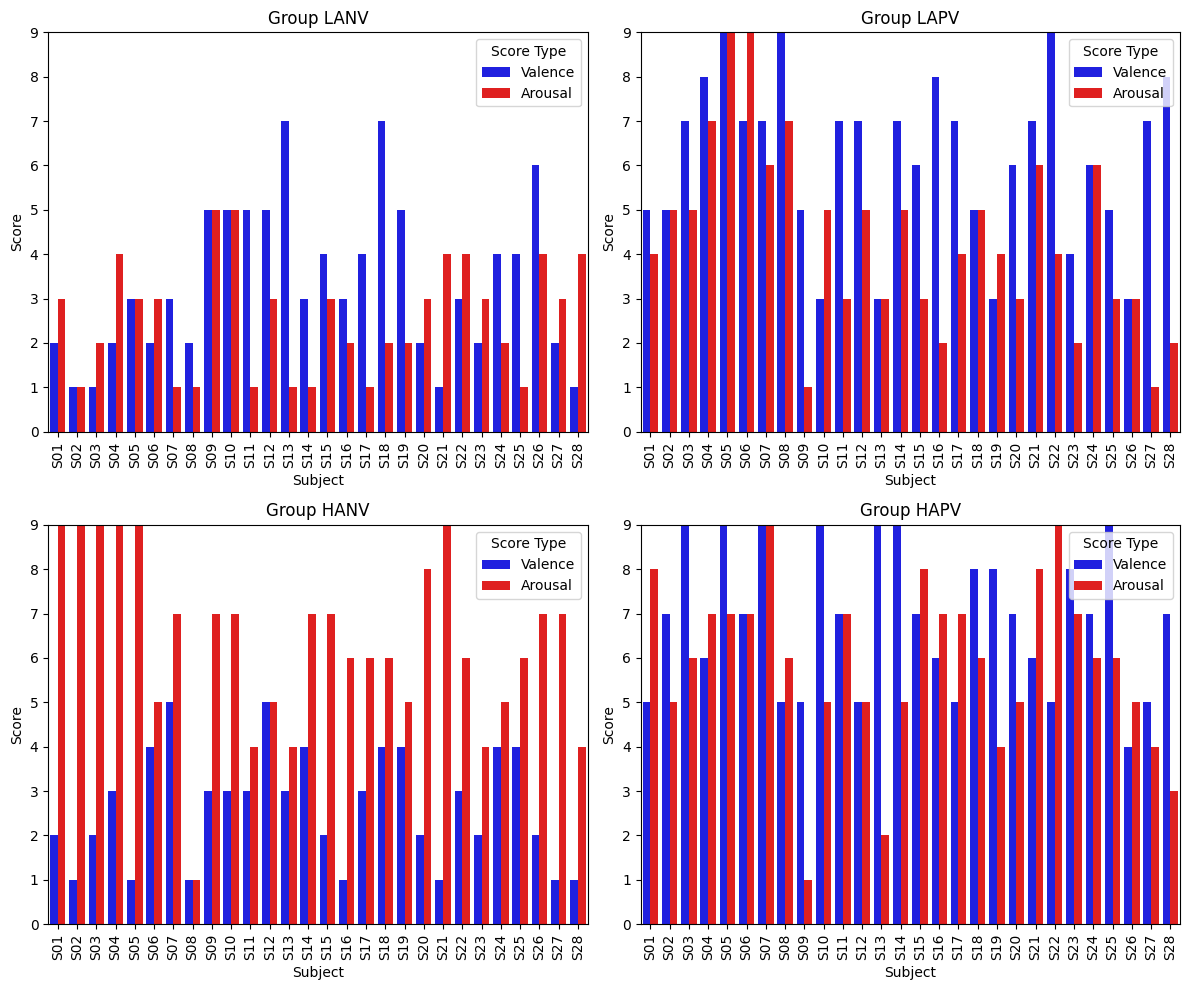

In [ ]:
# Plot the distributions of each group

name_order = ['LANV','LAPV','HANV','HAPV']
# create a figure with 4 subplots in a (2,2) grid
fig, axs = plt.pyplot.subplots(2, 2, figsize=(12, 10))

for i, sub_df in enumerate(sub_dfs):
    ax = axs[i // 2, i % 2]  # Select the correct subplot

    # Melt the dataframe to have 'Valence' and 'Arousal' as a single column
    melted_df = sub_df.melt(id_vars=['Subject'], value_vars=['Valence', 'Arousal'], var_name='Score_Type', value_name='Score')

    sns.barplot(x='Subject', y='Score', hue='Score_Type', data=melted_df, ax=ax, palette={'Valence': 'blue', 'Arousal': 'red'})

    ax.set_title(f'Group {name_order[i]}')
    ax.set_ylabel('Score')
    ax.set_xlabel('Subject')
    ax.tick_params(axis='x', rotation=90)
    ax.legend(title='Score Type')
    ax.set_ylim(0, 9) # Set the y-axis limit

plt.pyplot.tight_layout()
plt.pyplot.show()

In [ ]:
# Calculate average, stddev, variance
def calculate_stats(df, row_name):
  stats = []
  for i, sub_df in enumerate(sub_dfs):
      mean = sub_df[row_name].mean()
      std = sub_df[row_name].std()
      var = sub_df[row_name].var()
      stats.append({
          'Group': groups[i],
          'Name': name_order[i],
          'Mean': mean,
          'StdDev': std,
          'Variance': var
      })

  stats_df = pd.DataFrame(stats)

  # Reorder the DataFrame
  desired_order = ['HAPV', 'HANV', 'LANV', 'LAPV']
  stats_df['Name'] = pd.Categorical(stats_df['Name'], categories=desired_order, ordered=True)
  stats_df = stats_df.sort_values('Name')
  return stats_df
valence_stats_df = calculate_stats(df, 'Valence')
arousal_stats_df = calculate_stats(df, 'Arousal')

display(arousal_stats_df)
display(valence_stats_df)


,Group,Name,Mean,StdDev,Variance
3,G4.pdf,HAPV,5.892857,1.931019,3.728836
2,G3.pdf,HANV,6.357143,1.985396,3.941799
0,G1.pdf,LANV,2.571429,1.288944,1.661376
1,G2.pdf,LAPV,4.357143,2.094336,4.386243


,Group,Name,Mean,StdDev,Variance
3,G4.pdf,HAPV,6.892857,1.617938,2.617725
2,G3.pdf,HANV,2.642857,1.282771,1.645503
0,G1.pdf,LANV,3.357143,1.768328,3.126984
1,G2.pdf,LAPV,6.178571,1.846991,3.411376


In [ ]:
HAPV_df = sub_dfs[3][['Valence', 'Arousal', 'Boring', 'Calm','Horrible', 'Funny']]
HANV_df = sub_dfs[2][['Valence', 'Arousal', 'Boring', 'Calm','Horrible', 'Funny']]
LANV_df = sub_dfs[0][['Valence', 'Arousal', 'Boring', 'Calm','Horrible', 'Funny']]
LAPV_df = sub_dfs[1][['Valence', 'Arousal', 'Boring', 'Calm','Horrible', 'Funny']]

melted_HAPV = HAPV_df.melt(var_name='Parameter', value_name='Score')
melted_HANV = HANV_df.melt(var_name='Parameter', value_name='Score')
melted_LANV = LANV_df.melt(var_name='Parameter', value_name='Score')
melted_LAPV = LAPV_df.melt(var_name='Parameter', value_name='Score')


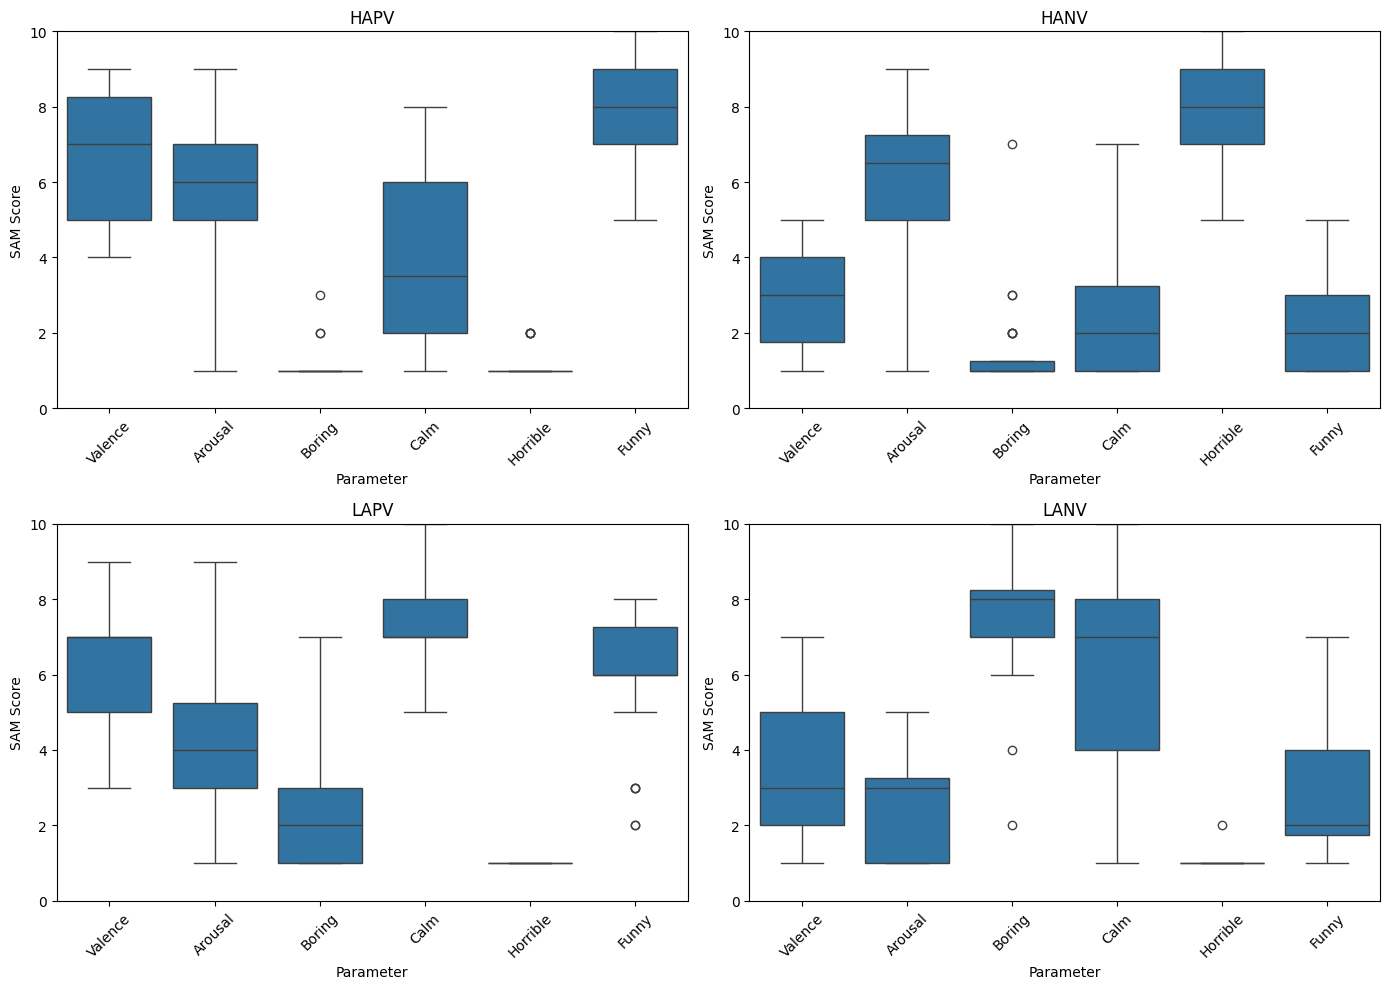

In [ ]:
fig, axs = plt.pyplot.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten() # Flatten the axes array

melted_dfs = [melted_HAPV, melted_HANV, melted_LAPV, melted_LANV]
titles = ['HAPV', 'HANV', 'LAPV', 'LANV']

for i, melted_df in enumerate(melted_dfs):
    sns.boxplot(x='Parameter', y='Score', data=melted_df, ax=axs[i], whis=2) # Added whis parameter
    axs[i].set_title(titles[i])
    axs[i].set_ylabel('SAM Score')
    axs[i].set_ylim(0, 10)
    axs[i].tick_params(axis='x', rotation=45)

plt.pyplot.tight_layout()
plt.pyplot.show()

## Visualizations

In [ ]:
import kagglehub
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
path = kagglehub.dataset_download("sigfest/database-for-emotion-recognition-system-gameemo")

frames_raw = []
frames_processed = []

# Search every subject's directory for datasets
for i in range(1, 29):
    base_dir = os.path.join(path, "GAMEEMO", f"(S{i:02})")
    csv_dir = ".csv format"
    raw_dir = os.path.join(base_dir, "Raw EEG Data", csv_dir)
    processed_dir = os.path.join(base_dir, "Preprocessed EEG Data", csv_dir)

    # Search every game CSV file
    for j in range (1, 5):
        csv_raw = os.path.join(raw_dir, f"S{i:02}G{j}AllRawChannels.csv")
        # For some godforsaken reason, CSV files in the same structure do not have consistent names
        if os.path.exists(csv_raw):
            df_raw = pd.read_csv(csv_raw)
        else:
            df_raw = pd.read_csv(os.path.join(raw_dir, f"S{i:02}G{j}AllChannels.csv"))
        df_processed = pd.read_csv(os.path.join(processed_dir, f"S{i:02}G{j}AllChannels.csv"))

        # Append Subject and Game information stored in filesystem to dataset
        df_raw["SUBJECT"] = i
        df_processed["SUBJECT"] = i
        df_raw["GAME"] = j
        df_processed["GAME"] = j
        frames_raw.append(df_raw)
        frames_processed.append(df_processed)

df_raw = pd.concat(frames_raw)
df_processed = pd.concat(frames_processed)

# Clean bad columns
df_raw = df_raw.dropna(axis=1, how="all")
df_processed = df_processed.dropna(axis=1, how="all")

df_raw.head()

100%|██████████| 1.70G/1.70G [00:15<00:00, 119MB/s]

Extracting files...


,AF3,AF4,F3,F4,F7,F8,FC5,FC6,O1,O2,P7,P8,T7,T8,SUBJECT,GAME
0,-35.1282,-16.1538,-44.8718,1.7949,44.8716,-1.7949,-5.8975,-3.8462,27.4360,-10.5127,5.8975,7.9487,12.5640,18.2051,1,1
1,-32.5642,-22.3079,-47.9487,-11.0256,40.2561,-16.7949,-20.8975,-2.8206,20.2561,2.8206,20.2561,5.8972,19.2307,4.3591,1,1
2,-27.1794,-13.8459,-39.4871,-3.0769,47.1794,-1.7949,-5.8975,-1.5383,31.2820,-4.1028,10.2566,9.7434,17.9485,11.2820,1,1
3,-32.0515,-14.6157,-42.3079,-4.3589,42.3076,3.8462,-11.0259,-2.3076,22.3076,-11.0259,3.3330,2.3076,7.4355,10.5127,1,1
4,-27.1794,-13.8462,-40.5127,-5.1279,47.1797,0.0000,-15.8975,0.5127,19.4873,-2.0513,10.7690,0.0000,11.7949,11.2822,1,1


/tmp/ipython-input-3538966535.py:162: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[idx], freqs[idx])


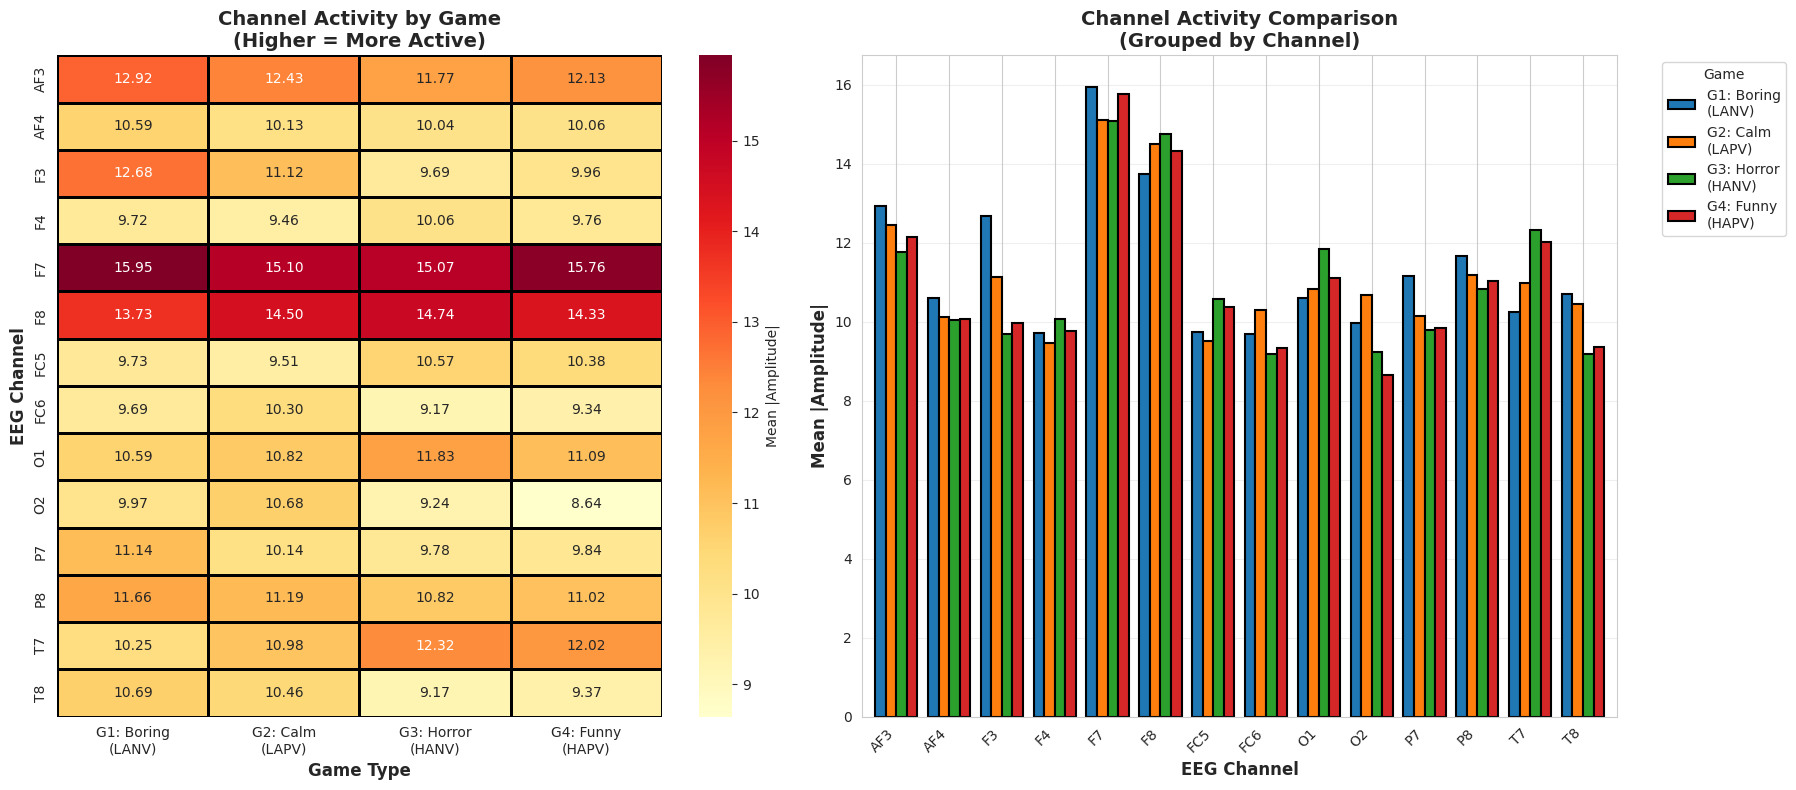

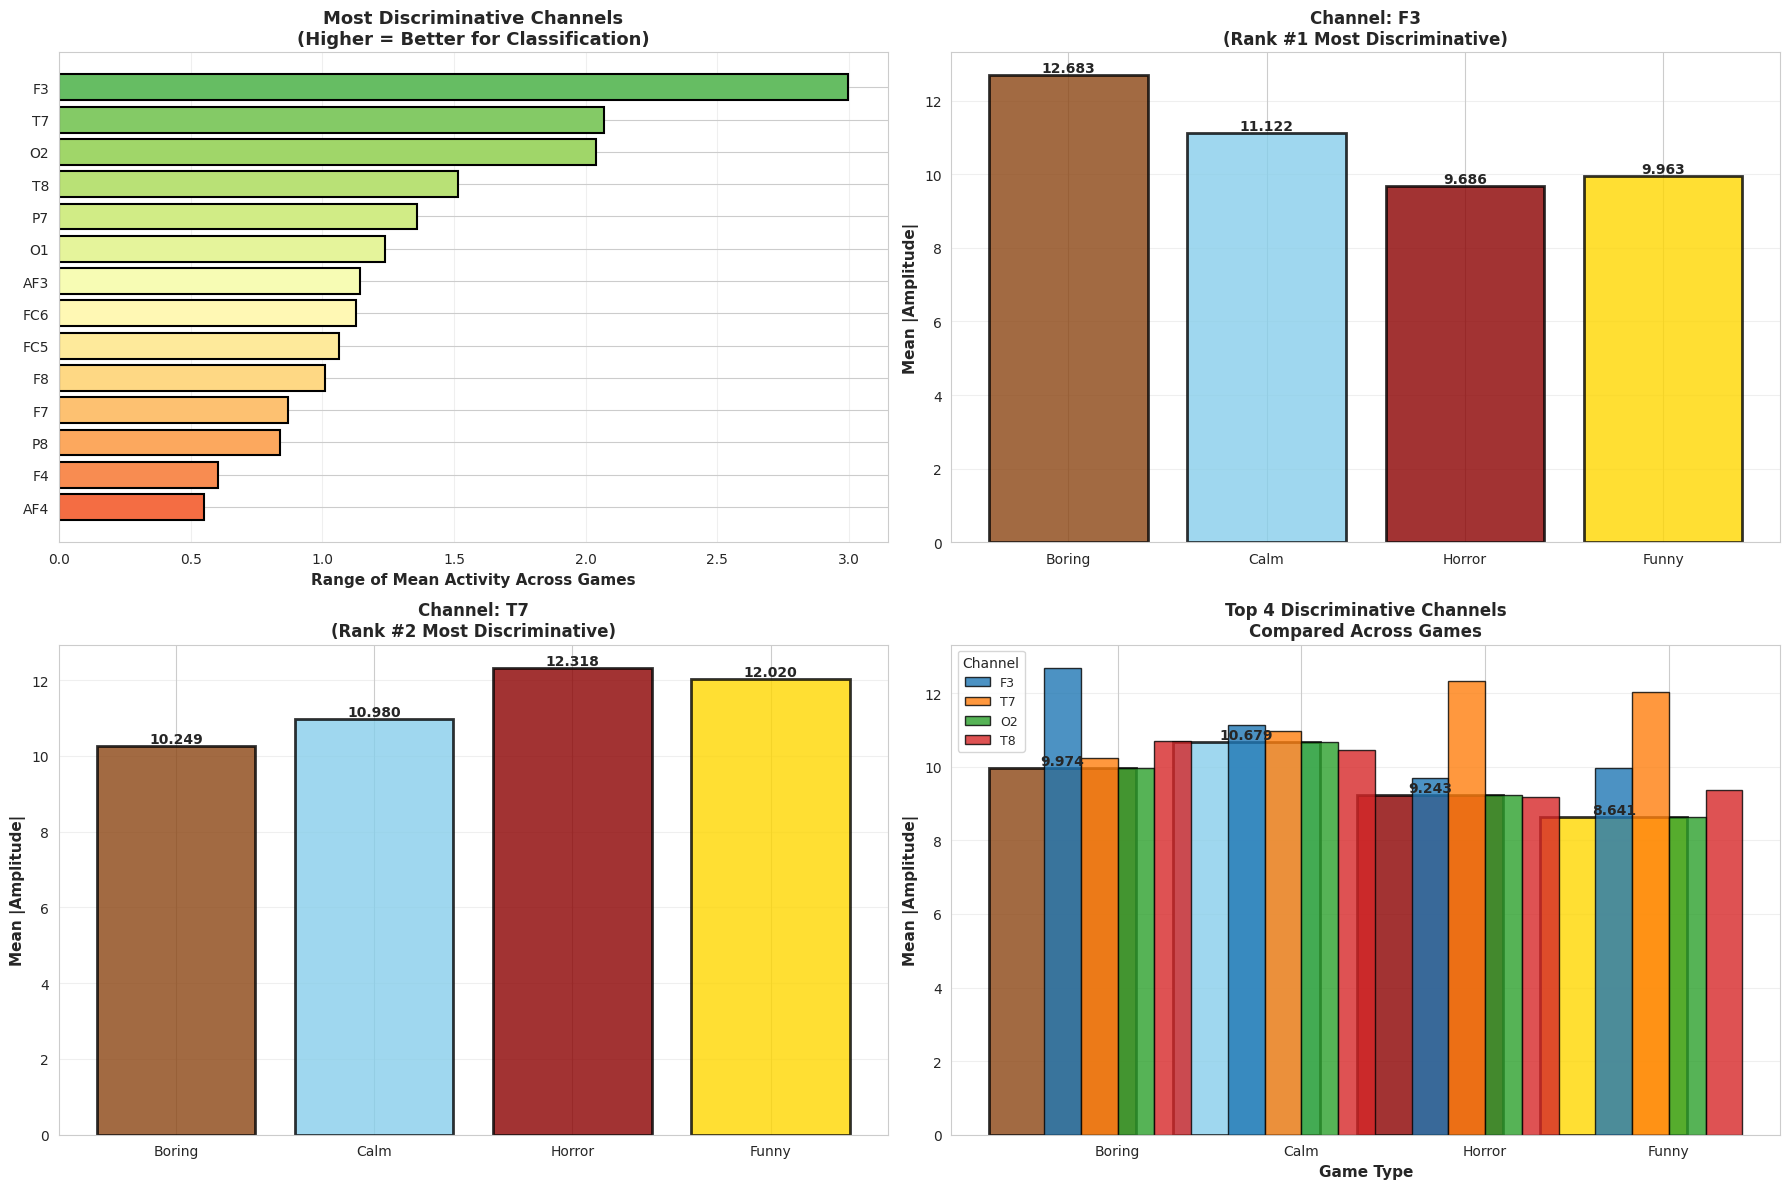

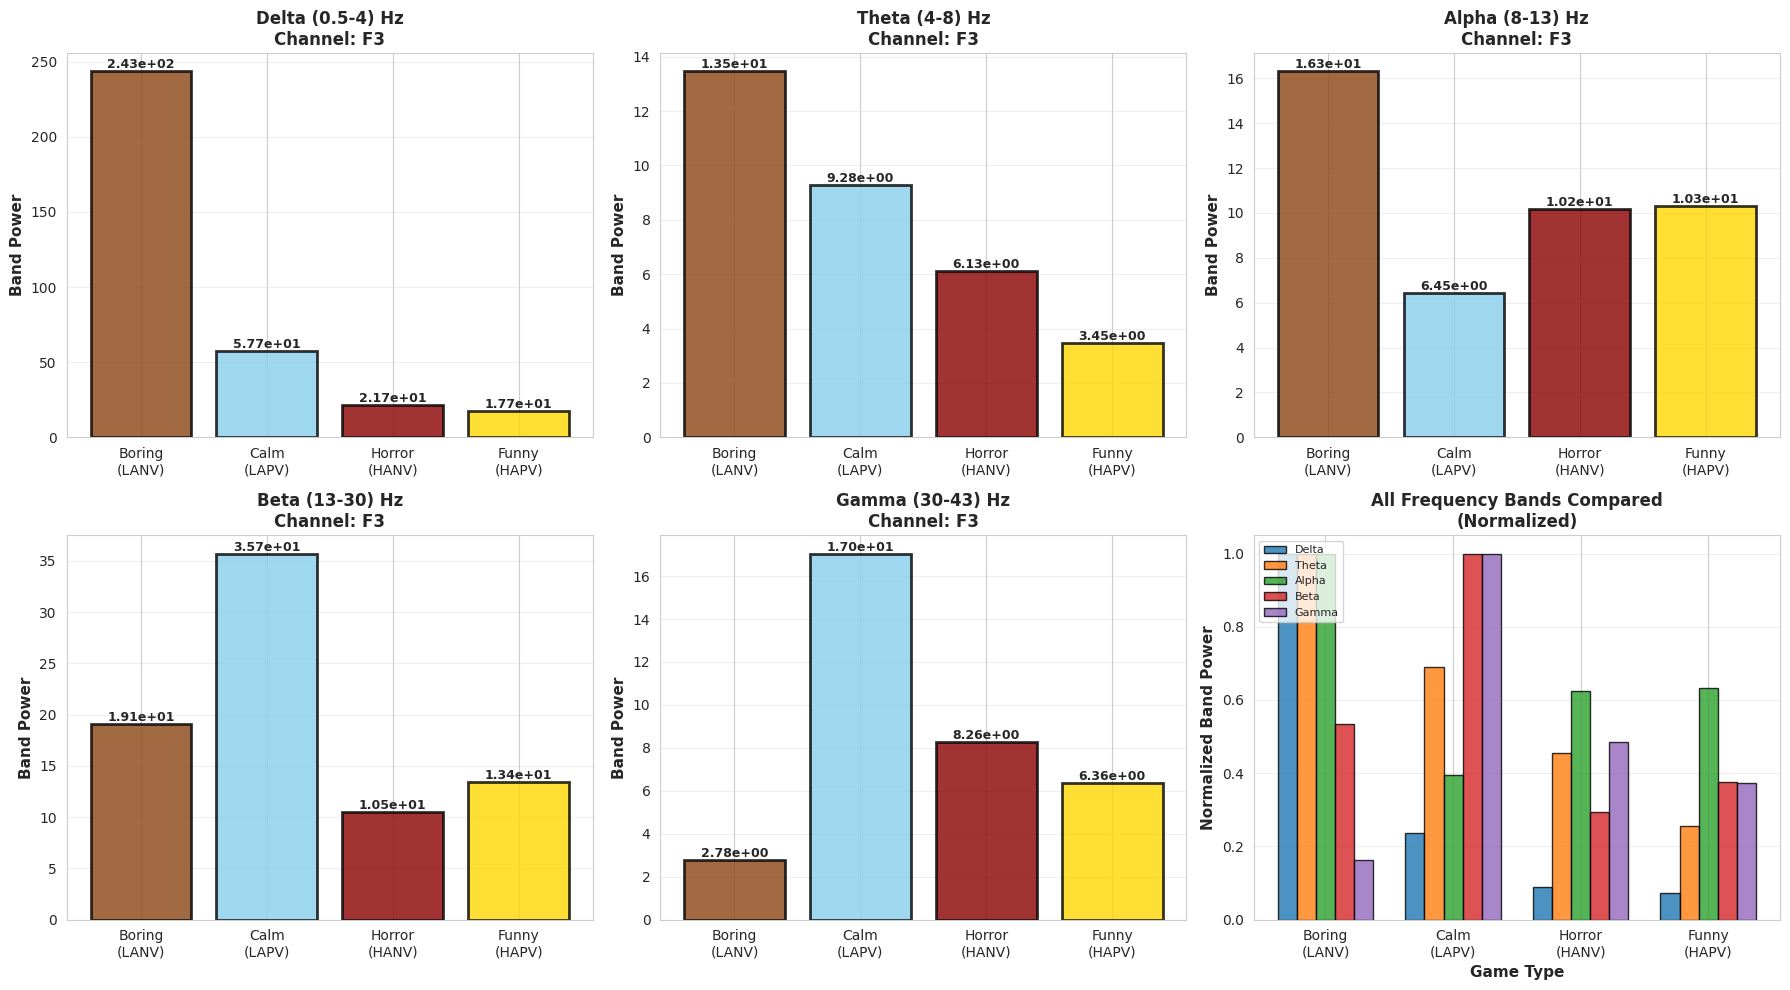

In [ ]:
import seaborn as sns
from scipy import signal
from scipy.stats import pearsonr

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Channel Activity Heatmap
def plot_channel_heatmap_by_game(df_processed):
    channels = [col for col in df_processed.columns if col not in ['SUBJECT', 'GAME']]
    game_labels = ['G1: Boring\n(LANV)', 'G2: Calm\n(LAPV)',
                   'G3: Horror\n(HANV)', 'G4: Funny\n(HAPV)']

    # Calculate mean absolute amplitude for each channel-game combination
    channel_activity = []
    for game in range(1, 5):
        game_data = df_processed[df_processed['GAME'] == game][channels]
        channel_activity.append(game_data.abs().mean())

    activity_df = pd.DataFrame(channel_activity, index=game_labels).T

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    sns.heatmap(activity_df, annot=True, fmt='.2f', cmap='YlOrRd',
                ax=axes[0], cbar_kws={'label': 'Mean |Amplitude|'},
                linewidths=1, linecolor='black')
    axes[0].set_title('Channel Activity by Game\n(Higher = More Active)',
                      fontsize=14, weight='bold')
    axes[0].set_xlabel('Game Type', fontsize=12, weight='bold')
    axes[0].set_ylabel('EEG Channel', fontsize=12, weight='bold')

    activity_df.plot(kind='bar', ax=axes[1], width=0.8, edgecolor='black', linewidth=1.5)
    axes[1].set_title('Channel Activity Comparison\n(Grouped by Channel)',
                      fontsize=14, weight='bold')
    axes[1].set_xlabel('EEG Channel', fontsize=12, weight='bold')
    axes[1].set_ylabel('Mean |Amplitude|', fontsize=12, weight='bold')
    axes[1].legend(title='Game', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(axis='y', alpha=0.3)
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    return fig

# Top Discriminative Channels - Which channels differ most between games
def plot_discriminative_channels(df_processed):
    channels = [col for col in df_processed.columns if col not in ['SUBJECT', 'GAME']]
    game_labels = ['Boring', 'Calm', 'Horror', 'Funny']

    # Calculate variance across games for each channel (high variance = discriminative)
    channel_variance = []
    channel_ranges = []

    for channel in channels:
        game_means = []
        for game in range(1, 5):
            game_data = df_processed[df_processed['GAME'] == game][channel]
            game_means.append(game_data.abs().mean())

        variance = np.var(game_means)
        range_val = max(game_means) - min(game_means)
        channel_variance.append({'Channel': channel, 'Variance': variance,
                                'Range': range_val, 'Game_Means': game_means})

    var_df = pd.DataFrame(channel_variance).sort_values('Range', ascending=False)

    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # Plot 1: Ranking of discriminative channels
    ax = axes[0, 0]
    colors_rank = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(var_df)))
    ax.barh(var_df['Channel'], var_df['Range'], color=colors_rank,
            edgecolor='black', linewidth=1.5)
    ax.set_xlabel('Range of Mean Activity Across Games', fontsize=11, weight='bold')
    ax.set_title('Most Discriminative Channels\n(Higher = Better for Classification)',
                 fontsize=13, weight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()

    # Plot 2-5: Top 4 discriminative channels across games
    top_channels = var_df.head(4)['Channel'].values
    colors_game = ['#8B4513', '#87CEEB', '#8B0000', '#FFD700']

    for idx, channel in enumerate(top_channels[:3]):
        ax = axes[(idx+1)//2, (idx+1)%2]

        means = []
        for game in range(1, 5):
            game_data = df_processed[df_processed['GAME'] == game][channel]
            means.append(game_data.abs().mean())

        bars = ax.bar(range(4), means, color=colors_game,
                      edgecolor='black', linewidth=2, alpha=0.8)

        for i, (bar, val) in enumerate(zip(bars, means)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.3f}',
                   ha='center', va='bottom', fontsize=10, weight='bold')

        ax.set_xticks(range(4))
        ax.set_xticklabels(game_labels)
        ax.set_ylabel('Mean |Amplitude|', fontsize=11, weight='bold')
        ax.set_title(f'Channel: {channel}\n(Rank #{idx+1} Most Discriminative)',
                    fontsize=12, weight='bold')
        ax.grid(axis='y', alpha=0.3)

    # Plot 4: Summary comparison of top 4 channels
    ax = axes[1, 1]
    x = np.arange(4)
    width = 0.2

    for i, channel in enumerate(top_channels):
        means = []
        for game in range(1, 5):
            game_data = df_processed[df_processed['GAME'] == game][channel]
            means.append(game_data.abs().mean())

        ax.bar(x + i*width, means, width, label=channel,
               edgecolor='black', linewidth=1, alpha=0.8)

    ax.set_xlabel('Game Type', fontsize=11, weight='bold')
    ax.set_ylabel('Mean |Amplitude|', fontsize=11, weight='bold')
    ax.set_title('Top 4 Discriminative Channels\nCompared Across Games',
                fontsize=12, weight='bold')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(game_labels)
    ax.legend(title='Channel', loc='upper left', fontsize=9)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    return fig

# Frequency Band Power by Game
def plot_frequency_bands_by_game(df_processed, channel='AF3'):

    game_labels = ['Boring\n(LANV)', 'Calm\n(LAPV)', 'Horror\n(HANV)', 'Funny\n(HAPV)']
    colors = ['#8B4513', '#87CEEB', '#8B0000', '#FFD700']

    # Frequency bands (Hz)
    bands = {
        'Delta (0.5-4)': (0.5, 4),
        'Theta (4-8)': (4, 8),
        'Alpha (8-13)': (8, 13),
        'Beta (13-30)': (13, 30),
        'Gamma (30-43)': (30, 43)
    }

    fs = 128

    # Calculate band power for each game
    band_powers = {band: [] for band in bands.keys()}

    for game in range(1, 5):
        game_data = df_processed[df_processed['GAME'] == game][channel].values[:60*128]  # 30 sec

        # Calculate PSD
        freqs, psd = signal.welch(game_data, fs=fs, nperseg=512)

        # Calculate power in each band
        for band_name, (low, high) in bands.items():
            idx = np.logical_and(freqs >= low, freqs <= high)
            band_power = np.trapz(psd[idx], freqs[idx])
            band_powers[band_name].append(band_power)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    for idx, (band_name, powers) in enumerate(band_powers.items()):
        ax = axes[idx // 3, idx % 3]

        bars = ax.bar(range(4), powers, color=colors,
                      edgecolor='black', linewidth=2, alpha=0.8)

        for i, (bar, val) in enumerate(zip(bars, powers)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.2e}',
                   ha='center', va='bottom', fontsize=9, weight='bold')

        ax.set_xticks(range(4))
        ax.set_xticklabels(game_labels)
        ax.set_ylabel('Band Power', fontsize=11, weight='bold')
        ax.set_title(f'{band_name} Hz\nChannel: {channel}',
                    fontsize=12, weight='bold')
        ax.grid(axis='y', alpha=0.3)

    ax = axes[1, 2]
    x = np.arange(4)
    width = 0.15

    for i, (band_name, powers) in enumerate(band_powers.items()):
        powers_norm = np.array(powers) / max(powers)
        ax.bar(x + i*width, powers_norm, width, label=band_name.split('(')[0].strip(),
               edgecolor='black', linewidth=1, alpha=0.8)

    ax.set_xlabel('Game Type', fontsize=11, weight='bold')
    ax.set_ylabel('Normalized Band Power', fontsize=11, weight='bold')
    ax.set_title(f'All Frequency Bands Compared\n(Normalized)',
                fontsize=12, weight='bold')
    ax.set_xticks(x + width * 2)
    ax.set_xticklabels(game_labels)
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    return fig

if __name__ == "__main__":

    fig1 = plot_channel_heatmap_by_game(df_processed)
    plt.savefig('01_channel_heatmap_CLEAR.png', dpi=300, bbox_inches='tight')

    fig2 = plot_discriminative_channels(df_processed)
    plt.savefig('02_discriminative_channels.png', dpi=300, bbox_inches='tight')

    fig5 = plot_frequency_bands_by_game(df_processed, channel='F3')
    plt.savefig('05_frequency_bands.png', dpi=300, bbox_inches='tight')

    plt.show()

# Approach 1 - Paper Approach

## Load in features extracted

In [12]:
# simplified features (not including AF3_Alpha_DFA --> AF3_DFA) due to computation time
df = pd.read_csv('/content/simple_features_paper.csv', index_col=0)
columns_to_exclude = ['GAME', 'SUBJECT']
feature_cols = df.columns.drop(columns_to_exclude).tolist()
X = df[feature_cols]
y_raw = df['GAME']

In [13]:
X.head()

,AF3_DFA,AF3_SampEn,AF4_DFA,AF4_SampEn,F3_DFA,F3_SampEn,F4_DFA,F4_SampEn,F7_DFA,F7_SampEn,...,T8_Alpha_ShanE,T8_Beta_AvgE,T8_Beta_LogEE,T8_Beta_ShanE,T8_Delta_Theta_AvgE,T8_Delta_Theta_LogEE,T8_Delta_Theta_ShanE,T8_Gamma_AvgE,T8_Gamma_LogEE,T8_Gamma_ShanE
0,0.579104,1.823639,0.650728,1.674879,0.690639,1.578158,0.633377,1.676353,0.812943,1.158631,...,10.991757,0.479444,-9770.135144,11.092207,1.084013,-8147.032206,10.277446,0.085782,-18092.959424,11.285617
1,0.552689,1.899545,0.612152,1.690508,0.663858,1.650767,0.601045,1.828639,0.567687,1.898205,...,10.852051,0.541153,-9343.878548,11.099196,1.117898,-6916.849768,10.699465,0.098119,-16704.404161,11.314159
2,0.612671,1.825035,0.597360,1.773722,0.583715,1.582050,0.658613,1.772109,0.714514,1.317490,...,10.861183,0.493916,-9830.254995,11.022983,1.093758,-8414.051581,10.232382,0.097318,-17454.927201,11.144107
3,0.561531,1.771288,0.539234,1.784388,0.609282,1.679821,0.627861,1.800502,0.618895,1.868005,...,11.037869,0.450435,-10295.288234,11.031709,1.042797,-9959.062867,10.089006,0.103464,-16576.182696,11.315268
4,0.397365,1.836184,0.423077,1.914177,0.435878,1.854053,0.511992,1.894580,0.392648,1.670107,...,10.884555,0.457489,-10765.351336,10.947621,1.264405,-6383.955784,10.755001,0.075103,-18198.226267,11.386875


## Run Paper Replication

In [14]:
def per_class_accuracy_scorer(y_pred, y, class_label):
  """Calculates the True Positive Rate (Accuracy) for a single specific class."""
  y_true_class = (y == class_label)

  if y_true_class.sum() == 0:
    return np.nan

  correct_predictions = ((y == y_pred) & y_true_class).sum()
  total_class_samples = y_true_class.sum()

  return correct_predictions / total_class_samples


In [45]:
def run_replication(X, y_raw):

    # Multi-class target: 0 (G1/LANV), 1 (G2/LAPV), 2 (G3/HANV), 3 (G4/HAPV)
    label_encoder = LabelEncoder()
    y_multi = label_encoder.fit_transform(y_raw)

    # KNN Pipeline: K=6, weights='uniform'. Metric is Euclidean for stability (was Mahalanobis).
    pipe_knn = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=6,
                                    weights='uniform',
                                    metric='mahalanobis',
                                    metric_params={'VI': np.cov(X, rowvar= False)}))
        ])

    # SVM Pipeline: RBF, C=1.0, class_weight='balanced', max_iter=300
    pipe_svm = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(
            kernel='rbf',               # RBF Kernel
            C=1.0,                      # C (penalty parameter) is 1
            class_weight='balanced',    # Class weights are balanced
            max_iter=300,               # Max iteration is 300
            random_state=SEED,
            probability=False           # Standard for SVM classification output
        ))
    ])

    # Logistic Regression Pipeline
    pipe_lr = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(solver='liblinear', multi_class='ovr', random_state=SEED, max_iter=1000))
    ])

    models = {'KNN': pipe_knn, 'SVM': pipe_svm, 'LogReg': pipe_lr,'MLP': None}
    # MLP pipeline created inside the loop due to KerasClassifier requirements

    # Define scorers for each of the 4 classes (zones) + Overall Accuracy
    # Labels: 3=HAPV, 2=HANV, 1=LAPV, 0=LANV
    custom_scorers = {
        'G4_HAPV': make_scorer(per_class_accuracy_scorer, class_label=3),
        'G3_HANV': make_scorer(per_class_accuracy_scorer, class_label=2),
        'G2_LAPV': make_scorer(per_class_accuracy_scorer, class_label=1),
        'G1_LANV': make_scorer(per_class_accuracy_scorer, class_label=0),
        'Avg.': make_scorer(accuracy_score)
    }

    final_results_dfs = {}
    CV_SPLITS = 10

    for model_name, pipeline in models.items():

        # Rows structure matching the paper: HAPV, HANV, LAPV, LANV, Avg.
        rows = {'HAPV': [], 'HANV': [], 'LAPV': [], 'LANV': [], 'Avg.': []}

        for ch_idx, ch_name in enumerate(channel_names):

            # Slice the features for the current channel
            X_ch = X.filter(regex=f'^{ch_name}_')
            cv_strategy = KFold(n_splits=CV_SPLITS, shuffle=True, random_state=SEED)
            # Run cross-validation
            if model_name == "MLP":
                keras_model = KerasClassifier(
                    model=create_mlp_model(X_ch.shape[1]),
                    epochs=50,             # Number of training epochs per fold
                    batch_size=32,         # Batch size for gradient updates
                    verbose=0,             # Suppress training output
                    random_state=SEED,      # For reproducibility
                    )

                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('mlp', keras_model)
            ])
            elif model_name == "KNN":
                pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=6,
                                            weights='uniform',
                                            metric='mahalanobis',
                                            metric_params={'VI': np.cov(X_ch, rowvar= False)}))
                ])
                with warnings.catch_warnings():
                    # Suppress the specific FutureWarning related to multi_class in LogisticRegression
                    warnings.filterwarnings(
                        "ignore",
                        category=FutureWarning,
                        module='sklearn.linear_model._logistic'
                    )
                    warnings.filterwarnings(
                        "ignore",
                        category=UserWarning,
                        module='keras.src.saving.saving_lib'
                    )

            cv_results = cross_validate(
                pipeline,
                X_ch,
                y_multi,
                cv=cv_strategy,
                scoring=custom_scorers,
                return_train_score=False,
                n_jobs=1 # Sequential execution for stability
                )

            # Aggregate results (convert to percentage)
            # nanmean handles the NaNs resulting from unstable per-class scoring on small folds.
            rows['HAPV'].append(np.nanmean(cv_results['test_G4_HAPV']) * 100)
            rows['HANV'].append(np.nanmean(cv_results['test_G3_HANV']) * 100)
            rows['LAPV'].append(np.nanmean(cv_results['test_G2_LAPV']) * 100)
            rows['LANV'].append(np.nanmean(cv_results['test_G1_LANV']) * 100)
            rows['Avg.'].append(np.mean(cv_results['test_Avg.']) * 100)

        # Format the final table for the model
        df_table = pd.DataFrame(rows, index=channel_names).T
        df_table.index.name = 'Zone'
        final_results_dfs[model_name] = df_table

    print("## 📊 Replicated Multi-Class Classification Results Per Channel (Game/Zone)")

    for model_name, df_table in final_results_dfs.items():
        print(f"\n### {model_name} Classifier Accuracy (%)")
        df_table.columns.name = 'Channel'
        # Ensure the rows are in the paper's specified order
        df_ordered = df_table.reindex(['HAPV', 'HANV', 'LAPV', 'LANV', 'Avg.'])
        print(df_ordered.to_markdown(floatfmt=".1f"))


In [46]:
run_replication(X,y_raw)

## 📊 Replicated Multi-Class Classification Results Per Channel (Game/Zone)

### KNN Classifier Accuracy (%)
| Zone   |   AF3 |   AF4 |   F3 |   F4 |   F7 |   F8 |   FC5 |   FC6 |   O1 |   O2 |   P7 |   P8 |   T7 |   T8 |
|:-------|------:|------:|-----:|-----:|-----:|-----:|------:|------:|-----:|-----:|-----:|-----:|-----:|-----:|
| HAPV   |  21.7 |  20.8 | 13.3 | 21.4 | 31.2 | 22.2 |  11.1 |  18.5 | 29.3 | 40.5 | 18.8 | 38.1 | 37.8 | 35.0 |
| HANV   |  22.9 |  16.5 | 25.8 | 10.4 | 47.2 |  0.0 |  37.0 |  35.0 | 43.3 | 32.0 | 44.8 | 25.9 | 25.9 | 60.2 |
| LAPV   |   9.0 |  21.5 | 19.8 | 47.2 | 19.8 | 18.3 |  19.3 |  12.0 | 33.2 | 22.0 | 20.0 | 45.7 | 35.0 | 27.2 |
| LANV   |  11.7 |  18.7 | 27.5 | 28.7 | 12.7 | 35.0 |  37.6 |  34.5 | 19.0 | 15.7 | 23.5 | 23.7 | 15.1 | 14.5 |
| Avg.   |  16.0 |  18.8 | 21.4 | 33.8 | 21.4 | 18.7 |  28.7 |  23.4 | 28.7 | 22.3 | 29.4 | 32.3 | 29.3 | 32.1 |

### SVM Classifier Accuracy (%)
| Zone   |   AF3 |   AF4 |   F3 |   F4 |   F7 |   F8 |   FC5 |   FC6

## Run on all channels

In [47]:
def run_mass_cv_test(X, y_raw, debug=False):

    # Convert target names (game names) to numerical labels: G1(Boring), G2(Calm), G3(Horror), G4(Funny)
    # Encoded values: 0, 1, 2, 3 for G1, G2, G3, G4 respectively
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_raw)
    N_FEATURES = X.shape[1] # 455 features
    N_CLASSES = len(label_encoder.classes_) # 4 classes

    # CV STRATEGY AND SCORERS ---
    CV_SPLITS = 10
    cv_strategy = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=SEED)

    # Define custom scorers (using 'weighted' average as specified in the paper)
    scorers = {
        'accuracy': make_scorer(accuracy_score),
        'f1_score': make_scorer(f1_score, average='weighted', zero_division=0),
        'precision': make_scorer(precision_score, average='weighted', zero_division=0),
        'recall': make_scorer(recall_score, average='weighted', zero_division=0),
        # 'kappa': make_scorer(cohen_kappa_score, weights='linear')
    }

    #  MODEL PIPELINES

    # Logistic Regression Pipeline
    pipe_lr = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', random_state=SEED, max_iter=1000))
    ])

    cv_results_lr = cross_validate(
        pipe_lr, X, y, cv=cv_strategy, scoring=scorers, return_train_score=False, n_jobs=-1, return_estimator=True
    )
    if debug:
        print_cv_results(cv_results_lr, "Logistic Regression") # NOTE: Logistic Regression was not in the paper's comparison table, so we omit printing its result here to focus on the requested models (KNN, SVM, MLPNN).
        print_per_fold_accuracy(cv_results_lr, "Logistic Regression")

    # KNN Pipeline
    pipe_knn = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=6,
                                    weights='uniform',
                                    metric='mahalanobis',
                                    metric_params={'VI': np.cov(X, rowvar= False)}))
        ])

    cv_results_knn = cross_validate(
        pipe_knn, X, y, cv=cv_strategy, scoring=scorers, return_train_score=False, n_jobs=-1,
    )
    if debug:
        print_cv_results(cv_results_knn, "K-Nearest Neighbors (K=6)")
        print_per_fold_accuracy(cv_results_knn, "K-Nearest Neighbors (K=6)")


    # SVM Linear Pipeline
    pipe_svm_lin = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(
            kernel='linear',
            C=1.0,                      # C (penalty parameter) is 1
            class_weight='balanced',    # Class weights are balanced
            max_iter=1000,               # Max iteration is 1000
            random_state=SEED,
            probability=False           # Standard for SVM classification output
        ))
    ])

    cv_results_svm_lin = cross_validate(
        pipe_svm_lin, X, y, cv=cv_strategy, scoring=scorers, return_train_score=False, n_jobs=-1
    )
    if debug:
        print_cv_results(cv_results_svm_lin, "Support Vector Machine (SVM)")
        print_per_fold_accuracy(cv_results_svm_lin, "Support Vector Machine (SVM)")


    # SVM RBF Pipeline
    pipe_svm = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(
            kernel='rbf',               # RBF Kernel
            C=1.0,                      # C (penalty parameter) is 1
            class_weight='balanced',    # Class weights are balanced
            max_iter=300,               # Max iteration is 300
            random_state=SEED,
            probability=False           # Standard for SVM classification output
        ))
    ])

    cv_results_svm = cross_validate(
        pipe_svm, X, y, cv=cv_strategy, scoring=scorers, return_train_score=False, n_jobs=-1
    )
    if debug:
        print_cv_results(cv_results_svm, "Support Vector Machine with RBF (SVM)")
        print_per_fold_accuracy(cv_results_svm, "Support Vector Machine with RBF (SVM)")

    # Decision Tree Pipeline
    pipe_dt = Pipeline([
        ('scaler', StandardScaler()),
        ('dt', DecisionTreeClassifier(
            criterion='gini',         # Criterion for split quality ('gini' or 'entropy')
            max_depth=None,           # Maximum depth of the tree (None means unlimited)
            min_samples_split=2,      # Minimum number of samples required to split an internal node
            class_weight='balanced',
            random_state=SEED
        ))
    ])

    cv_results_dt = cross_validate(
        pipe_dt, X, y, cv=cv_strategy, scoring=scorers, return_train_score=False, n_jobs=-1
    )
    if debug:
        print_cv_results(cv_results_dt, "Decision Tree")
        print_per_fold_accuracy(cv_results_dt, "Decision Tree")

    # XGBoost Pipeline
    pipe_xgb = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', XGBClassifier(
            objective='binary:logistic',  # For binary classification (use 'multi:softmax' for multi-class)
            n_estimators=100,             # Number of boosting rounds (trees)
            learning_rate=0.1,            # Step size shrinkage used to prevent overfitting
            max_depth=3,                  # Maximum depth of a tree
            use_label_encoder=False,      # Suppress warning for older XGBoost versions
            eval_metric='logloss',        # Metric used for evaluation
            random_state=SEED             # For reproducible results
        ))
    ])

    cv_results_xgb = cross_validate(
        pipe_xgb,X, y, cv=cv_strategy, scoring=scorers, return_train_score=False, n_jobs=-1
    )
    if debug:
        print_cv_results(cv_results_xgb, "XGBoost")
        print_per_fold_accuracy(cv_results_xgb, "XGBoost")

    # # Wrap the Keras model using Scikeras
    keras_model = KerasClassifier(
        model=create_mlp_model(X.shape[1]),
        epochs=50,             # Number of training epochs per fold
        batch_size=32,         # Batch size for gradient updates
        verbose=0,             # Suppress training output
        random_state=SEED,      # For reproducibility
    )

    pipe_mlp = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', keras_model)
    ])

    cv_results_mlp = cross_validate(
        pipe_mlp, X, y, cv=cv_strategy, scoring=scorers, return_train_score=False, n_jobs=1
    )

    if debug:
        print_cv_results(cv_results_mlp, "Deep Multi-Layer Perceptron (MLPNN)")
        print_per_fold_accuracy(cv_results_mlp, "Deep Multi-Layer Perceptron (MLPNN)")

    # Summary Table of Results
    print("## 📊 Summary of Multi-class Classification Results")
    print("---")
    results_table = pd.DataFrame({
        'Classifier': ['Logistic','KNN (K=6)', 'SVM (Lin)', 'SVM (RBF)', 'DecisionTree','XGboost','MLPNN'],
        'Mean Accuracy': [np.mean(cv_results_lr['test_accuracy']),
                            np.mean(cv_results_knn['test_accuracy']),
                            np.mean(cv_results_svm_lin['test_accuracy']),
                            np.mean(cv_results_svm['test_accuracy']),
                            np.mean(cv_results_dt['test_accuracy']),
                            np.mean(cv_results_xgb['test_accuracy']),
                            np.mean(cv_results_mlp['test_accuracy'])]
    })

    # Displaying the results in a comparative table format.
    print(results_table)


In [48]:
run_mass_cv_test(X, y_raw, debug=True)

## 🏆 Results for Logistic Regression (Multi-class with 10-Fold CV)
---
**Accuracy**: 0.8053 (±0.1224)
**F1_score**: 0.7838 (±0.1464)
**Precision**: 0.8105 (±0.1552)
**Recall**: 0.8053 (±0.1224)



--- Detailed Per-Fold Accuracy for Logistic Regression ---
Fold 1: 0.6667
Fold 2: 0.7500
Fold 3: 0.9091
Fold 4: 0.6364
Fold 5: 0.6364
Fold 6: 0.9091
Fold 7: 0.8182
Fold 8: 0.9091
Fold 9: 0.8182
Fold 10: 1.0000
--------------------------------------------------
Mean Accuracy: 0.8053 (±0.1224)
--------------------------------------------------
## 🏆 Results for K-Nearest Neighbors (K=6) (Multi-class with 10-Fold CV)
---
**Accuracy**: 0.3992 (±0.1217)
**F1_score**: 0.3694 (±0.1292)
**Precision**: 0.4039 (±0.1844)
**Recall**: 0.3992 (±0.1217)



--- Detailed Per-Fold Accuracy for K-Nearest Neighbors (K=6) ---
Fold 1: 0.6667
Fold 2: 0.4167
Fold 3: 0.4545
Fold 4: 0.1818
Fold 5: 0.3636
Fold 6: 0.3636
Fold 7: 0.4545
Fold 8: 0.3636
Fold 9: 0.2727
Fold 10: 0.4545
----------------------------------------

## Run with PCA

In [49]:
def prepare_data_for_dim_reduction(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Separates the feature matrix (X) from the metadata columns (meta)
    and ensures numerical types.
    """

    # Identify feature columns (all columns that are not metadata)
    feature_cols = [col for col in df.columns if col not in METADATA_COLS and not col.startswith('Unnamed')]

    X = df[feature_cols].fillna(0)  # Handle NaN values, common after feature extraction
    meta = df[[col for col in df.columns if col not in feature_cols]]

    return X, meta

def apply_pca_dimensionality_reduction(
    X: pd.DataFrame,
    n_components: int = 0.95
) -> Tuple[pd.DataFrame, StandardScaler, PCA]:
    """
    Applies Principal Component Analysis (PCA) for linear dimensionality reduction.
    PCA maximizes variance retention.

    Args:
        X: The input feature DataFrame.
        n_components: Either an integer (number of components) or a float
                      (variance retention threshold, e.g., 0.95).

    Returns:
        The transformed DataFrame (X_pca), the fitted StandardScaler, and the fitted PCA object.
    """
    print(f"Starting PCA with n_components={n_components}...")

    # 1. Scale the data (Mandatory for PCA)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 2. Apply PCA
    # If n_components is float (e.g., 0.95), PCA retains that percentage of variance.
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    # 3. Create DataFrame for transformed data
    # Note: Column names are now Component_1, Component_2, etc.
    pca_cols = [f'PC_{i+1}' for i in range(X_pca.shape[1])]
    X_pca_df = pd.DataFrame(X_pca, index=X.index, columns=pca_cols)

    print(f"Original Features: {X.shape[1]}, Reduced Features: {X_pca_df.shape[1]}")

    # Calculate the explained variance ratio
    if isinstance(n_components, float):
        explained_variance = np.sum(pca.explained_variance_ratio_) * 100
        print(f"Total Variance Explained: {explained_variance:.2f}%")

    return X_pca_df, scaler, pca


In [56]:
def run_with_PCA(X, y_raw):
    # Transform to Principal Components (Reduces Dimensionality based on variance)
    X_pca, scaler, pca_model = apply_pca_dimensionality_reduction(X, n_components=0.95)
    run_mass_cv_test(X_pca, y_raw)


In [57]:
run_with_PCA(X, y_raw);

Starting PCA with n_components=0.95...
Original Features: 266, Reduced Features: 35
Total Variance Explained: 95.04%
## 📊 Summary of Multi-class Classification Results
---
     Classifier  Mean Accuracy
0      Logistic       0.609848
1     KNN (K=6)       0.188636
2     SVM (Lin)       0.777273
3     SVM (RBF)       0.831061
4  DecisionTree       0.492424
5       XGboost       0.635606
6         MLPNN       0.840909


## Run with GINI importance

In [58]:
def get_mean_feature_importance_rf(cv_results, feature_names, n_top: int = 40) -> pd.DataFrame:
    """
    Extracts, processes, and ranks feature importance (Mean Decrease in Impurity)
    from Random Forest models trained via cross_validate.

    Args:
        cv_results: The dictionary returned by sklearn.model_selection.cross_validate,
                    which MUST include the 'estimator' key (return_estimator=True).
        feature_names: A list of feature column names.
        n_top: Number of top features to return.

    Returns:
        A DataFrame containing the ranked features and their mean Gini importance score
        averaged across all CV folds.
    """
    # 1. Extract the trained model object for each fold
    trained_estimators = cv_results.get('estimator', [])

    if not trained_estimators:
        return pd.DataFrame({'Warning': ['No trained estimators found. Did cross_validate use return_estimator=True?']})

    all_importances = []

    for pipe in trained_estimators:
        # Get the Random Forest step from the Pipeline
        rf_model = pipe.named_steps['rf']
        all_importances.append(rf_model.feature_importances_)

    # 2. Aggregate: Calculate the mean importance vector across all folds
    # Shape is (n_folds, n_features) -> mean is taken across axis=0
    mean_importance_vector = np.mean(np.array(all_importances), axis=0)

    # 3. Rank and Format
    feature_importance = pd.Series(mean_importance_vector, index=feature_names)
    top_features = feature_importance.nlargest(n_top).reset_index()
    top_features.columns = ['Feature', 'Mean Gini Importance']

    return top_features

def run_with_gini_importance(X, y_raw, k=40):
    # lets do feature selection using random forest

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_raw)

    scorers = {'accuracy': make_scorer(accuracy_score)}
    CV_SPLITS = 10
    cv_strategy = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=SEED)

    # Define the Random Forest Pipeline
    pipe_rf = Pipeline([
        ('scaler', StandardScaler()),
        # Scaling is technically not required for the RF algorithm itself,
        # but kept here for consistency with the overall pipeline structure.
        ('rf', RandomForestClassifier(
            n_estimators=100,            # Number of trees
            criterion='gini',            # Use Gini impurity for importance
            max_depth=None,              # Allow trees to grow fully initially
            class_weight='balanced',     # Handle class imbalance
            random_state=SEED,
            n_jobs=-1                    # Use all cores for faster training
        ))
    ])


    cv_results_rf = cross_validate(
        pipe_rf,
        X,
        y,
        cv=cv_strategy,
        scoring=scorers,
        return_train_score=False,
        n_jobs=-1,
        return_estimator=True # <--- MUST BE TRUE
    )

    # Pass the results and your feature list to the new function:
    feature_names = X.columns.tolist()
    top_rf_features = get_mean_feature_importance_rf(cv_results_rf, feature_names, n_top=k)
    print(top_rf_features.to_markdown(index=False, floatfmt=".4f"))

    filtered_col = list(top_rf_features['Feature'])
    X_reduced = X[filtered_col]
    run_mass_cv_test(X_reduced, y_raw)


In [59]:
run_with_gini_importance(X, y_raw)

| Feature               |   Mean Gini Importance |
|:----------------------|-----------------------:|
| T8_DFA                |                 0.0173 |
| AF4_Alpha_AvgE        |                 0.0143 |
| T8_Delta_Theta_AvgE   |                 0.0098 |
| F3_STD                |                 0.0096 |
| T8_STD                |                 0.0089 |
| P8_Delta_Theta_ShanE  |                 0.0086 |
| P7_STD                |                 0.0086 |
| AF4_DFA               |                 0.0085 |
| F3_Hjorth_Act         |                 0.0085 |
| O1_Hjorth_Act         |                 0.0084 |
| F4_SampEn             |                 0.0082 |
| T8_Delta_Theta_LogEE  |                 0.0080 |
| T8_Hjorth_Act         |                 0.0079 |
| F7_STD                |                 0.0079 |
| O1_STD                |                 0.0076 |
| P7_DFA                |                 0.0073 |
| F8_Gamma_AvgE         |                 0.0073 |
| F7_DFA                |      

# Approach 2 - MLP with Windowed Data

## Find the best window

In [65]:
def run_cv_test_mlp(X, y_raw, groups, debug=False):
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_raw)
    N_FEATURES = X.shape[1] # 455 features
    N_CLASSES = len(label_encoder.classes_) # 4 classes

    # CV STRATEGY AND SCORERS ---
    CV_SPLITS = 10
    cv_strategy = GroupKFold(n_splits=CV_SPLITS)

    # Define custom scorers (using 'weighted' average as specified in the paper)
    scorers = {
        'accuracy': make_scorer(accuracy_score),
        'f1_score': make_scorer(f1_score, average='weighted', zero_division=0),
        'precision': make_scorer(precision_score, average='weighted', zero_division=0),
        'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    }


    def create_mlp_model(input_dim=N_FEATURES, output_dim=N_CLASSES, seed=SEED):
        """Creates the MLP model exactly as defined in the notebook (Cell 9)."""

        tf.random.set_seed(seed)

        model = Sequential([
            Input(shape=(input_dim,)),
            Dense(128, activation='relu', name='Hidden_1'),
            Dropout(0.3),
            Dense(64, activation='relu', name='Hidden_2'),
            Dropout(0.3),
            Dense(32, activation='relu', name='Hidden_3'),
            Dense(output_dim, activation='softmax', name='Output_Layer') # Softmax for multi-class
        ])

        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy', # Used when y is integer-encoded (0, 1, 2...)
            metrics=['accuracy']
        )
        return model

    # # Wrap the Keras model using Scikeras
    keras_model = KerasClassifier(
        model=create_mlp_model,
        epochs=50,             # Number of training epochs per fold
        batch_size=32,         # Batch size for gradient updates
        verbose=0,             # Suppress training output
        random_state=SEED,      # For reproducibility
    )

    pipe_mlp = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', keras_model)
    ])

    # Run the cross-validation for MLPNN
    # Deep learning models can be sensitive with n_jobs=-1; running with n_jobs=1 as in the final notebook cell.
    cv_results_mlp = cross_validate(
        pipe_mlp, X, y, cv=cv_strategy, scoring=scorers, groups=groups, return_train_score=False, n_jobs=1
    )

    if debug:
        print_cv_results(cv_results_mlp, "Deep Multi-Layer Perceptron (MLPNN)")
        print_per_fold_accuracy(cv_results_mlp, "Deep Multi-Layer Perceptron (MLPNN)")


In [67]:
# run different window to determine best one (we only look at MLP because most robust in previous runs)

def find_best_window(data_dir):
     # get all the files in a directory
    all_simple_window_features = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('eeg_bandpower_features_windowed') and f.endswith('.csv')]
    # STEP 1: Try out different windows
    for file in all_simple_window_features:
        df = pd.read_csv(file)
        if df.empty:
            raise ValueError("DataFrame is empty.")

        columns_to_exclude = ['GAME', 'SUBJECT']
        feature_cols = df.columns.drop(columns_to_exclude, errors='ignore').tolist()

        X = df[feature_cols]
        y_raw = df['GAME']
        groups = df['SUBJECT'].values
        print(f"Running on file {file}")
        run_cv_test_mlp(X, y_raw, groups, debug=True)


In [ ]:
find_best_window('/content/bandpower_features')

Running on file /content/bandpower_features/eeg_bandpower_features_windowed_4.0_2.0.csv
## 🏆 Results for Deep Multi-Layer Perceptron (MLPNN) (Multi-class with 10-Fold CV)
---
**Accuracy**: 0.7075 (±0.0406)
**F1_score**: 0.7071 (±0.0408)
**Precision**: 0.7119 (±0.0413)
**Recall**: 0.7075 (±0.0406)



--- Detailed Per-Fold Accuracy for Deep Multi-Layer Perceptron (MLPNN) ---
Fold 1: 0.7106
Fold 2: 0.7646
Fold 3: 0.6926
Fold 4: 0.7089
Fold 5: 0.7359
Fold 6: 0.7061
Fold 7: 0.6807
Fold 8: 0.7382
Fold 9: 0.7297
Fold 10: 0.6073
--------------------------------------------------
Mean Accuracy: 0.7075 (±0.0406)
--------------------------------------------------
Running on file /content/bandpower_features/eeg_bandpower_features_windowed_12.0_8.0.csv


## Train with best windows

In [ ]:
filepath = '/content/bandpower_features/eeg_bandpower_features_windowed_12.0_8.0.csv'
df = pd.read_csv(filepath)
if df.empty:
    raise ValueError("DataFrame is empty.")

columns_to_exclude = ['GAME', 'SUBJECT']
feature_cols = df.columns.drop(columns_to_exclude, errors='ignore').tolist()

X = df[feature_cols]
y_raw = df['GAME']
groups = df['SUBJECT'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

N_FEATURES = X.shape[1]
N_CLASSES = len(label_encoder.classes_)


In [ ]:

def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy curves over epochs.
    """
    history_df = pd.DataFrame(history.history)
    epochs = range(1, len(history_df) + 1)

    # 1. Loss Plot
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_df['loss'], label='Training Loss', color='#1f77b4')
    plt.plot(epochs, history_df['val_loss'], label='Validation Loss', color='#ff7f0e')
    plt.title('Training and Validation Loss (Subject-Independent Split)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (sparse_categorical_crossentropy)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # 2. Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_df['accuracy'], label='Training Accuracy', color='#1f77b4')
    plt.plot(epochs, history_df['val_accuracy'], label='Validation Accuracy', color='#ff7f0e')
    plt.title('Training and Validation Accuracy (Subject-Independent Split)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

def create_mlp_model(input_dim: int, output_dim: int, seed: int = SEED) -> tf.keras.Model:
    """Creates the MLP model."""
    tf.random.set_seed(seed)

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu', name='Hidden_1'),
        Dropout(0.3),
        Dense(64, activation='relu', name='Hidden_2'),
        Dropout(0.3),
        Dense(32, activation='relu', name='Hidden_3'),
        Dense(output_dim, activation='softmax', name='Output_Layer')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Simple model training
def run_model_training(X, y, groups):

    """Runs the MLP model training with subject-aware train/validation split."""
    # Use GroupShuffleSplit to ensure all samples from a subject go to EITHER train or validation.
    # We create one split (n_splits=1) with 20% of the data/groups reserved for validation.
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    train_idx, val_idx = next(gss.split(X, y, groups=groups))

    # Slice the data using the indices
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Verify no subjects were split
    if len(set(groups[train_idx]) & set(groups[val_idx])) == 0:
        print("Subject Integrity Check: PASSED (No leakage detected).")
    else:
        print("Subject Integrity Check: FAILED (Some subjects appear in both sets).")

    # 1. Instantiate the scaler and model separately
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # 2. Create and compile the Keras model
    mlp_model = create_mlp_model(N_FEATURES)

    # 3. Train the model and capture the history
    print("\nStarting MLP training...")
    history = mlp_model.fit(
        X_train_scaled,
        y_train,
        epochs=50,
        batch_size=32,
        verbose=2, # Print output per epoch
        validation_data=(X_val_scaled, y_val),
        shuffle=True # Shuffle training data within each epoch
    )

    # 4. Plot the results
    plot_training_history(history)

    print("\nTraining complete. Loss curves plotted.")

## Hyper Paramater Tuning

In [ ]:
def create_mlp_model_v2(
    input_dim: int,
    output_dim: int,
    learning_rate: float = 0.001,
    dropout_rate: float = 0.3,
    first_layer_neurons: int = 128,
    l2_lambda: float = 0.0,
    seed: int = SEED
) -> tf.keras.Model:
    """
    Creates the MLP model with all relevant hyperparameters exposed for tuning.
    """
    tf.random.set_seed(seed)
    regularizer = l2(l2_lambda) if l2_lambda > 0 else None

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(first_layer_neurons, activation='relu', name='Hidden_1', kernel_regularizer=regularizer),
        Dropout(dropout_rate),
        Dense(64, activation='relu', name='Hidden_2', kernel_regularizer=regularizer),
        Dropout(dropout_rate),
        Dense(32, activation='relu', name='Hidden_3', kernel_regularizer=regularizer),
        Dense(output_dim, activation='softmax', name='Output_Layer')
    ])

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def run_tuning_experiment(X_full,y_full, groups, n_iter: int = 20) -> Dict[str, Any]:

    N_FEATURES = X_full.shape[1]
    N_CLASSES = len(label_encoder.classes_)


    keras_model_wrapper = KerasClassifier(
        model=create_mlp_model_v2,
        epochs=50,
        verbose=0,
        random_state=SEED,
        model__input_dim=N_FEATURES,
        model__output_dim=N_CLASSES,
        model__seed=SEED
    )

    pipe_mlp = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', keras_model_wrapper)
    ])

    # Define the search space for the most critical parameters
    param_dist = {
        # Optimizers parameters
        'mlp__model__learning_rate': [1e-3, 5e-4, 1e-4, 5e-5],
        'mlp__batch_size': [16, 32, 64],

        # Regularization parameters (critical for avoiding overfitting on small data)
        'mlp__model__dropout_rate': uniform(0.1, 0.5), # From 0.1 up to 0.6
        'mlp__model__l2_lambda': [0.0, 1e-4, 1e-3, 5e-3], # Try no L2, mild, medium, and strong L2

        # Architecture parameters
        'mlp__model__first_layer_neurons': randint(100, 200),
    }

    # Define Group Cross-Validation Strategy
    CV_SPLITS = 5
    cv_strategy = GroupKFold(n_splits=CV_SPLITS)

    # --- 5. Perform Randomized Search ---
    print(f"Starting Randomized Search with {n_iter} iterations using GroupKFold...")

    random_search = RandomizedSearchCV(
        estimator=pipe_mlp,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring=make_scorer(accuracy_score),
        cv=cv_strategy,
        verbose=1,
        random_state=SEED,
        n_jobs=1 # Deep learning models must run sequentially
    )

    tf.get_logger().setLevel('ERROR')
    random_search.fit(X_full, y_full, groups=groups)

    print("\n--- Hyperparameter Search Complete ---")
    print(f"Best Mean Accuracy: {random_search.best_score_:.4f}")
    print(f"Best Parameters Found: {random_search.best_params_}")

    # --- 6. OPTIONAL: Plot Best Model Loss Curve (Uses Subject-Aware Split) ---
    print("\nTraining best model on a single split to visualize loss curves...")

    # Prepare data for final plotting using GroupShuffleSplit for subject isolation
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    train_idx, val_idx = next(gss.split(X_full, y_full, groups=groups))

    X_train, X_val = X_full.iloc[train_idx], X_full.iloc[val_idx]
    y_train, y_val = y_full[train_idx], y_full[val_idx]

    # Retrain the final model on the best parameters
    best_pipe = random_search.best_estimator_

    # Extract best parameters for Keras fit
    best_params = random_search.best_params_
    epochs = best_params.get('mlp__epochs', 50)
    batch_size = best_params.get('mlp__batch_size', 32)

    # Refit the scaler on the training data
    scaler = best_pipe.named_steps['scaler']
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Get the Keras model (or rebuild it with best params for proper history capture)
    best_keras_model = best_pipe.named_steps['mlp'].model_

    # Recompile if necessary (e.g., if learning_rate was tuned)
    best_lr = best_params.get('mlp__model__learning_rate', 0.001)
    best_keras_model.compile(optimizer=Adam(learning_rate=best_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train and capture history
    history = best_keras_model.fit(
        X_train_scaled,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        validation_data=(X_val_scaled, y_val),
        shuffle=True
    )

    # Plot the results
    plot_training_history(history)

    return {
        'best_score': random_search.best_score_,
        'best_params': random_search.best_params_
    }


In [ ]:
run_tuning_experiment(X, y, groups)

## Final Model Eval

In [ ]:
def final_model_eval(X_full, y_full, groups):
    # Prepare data for final plotting using GroupShuffleSplit for subject isolation

    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
    train_idx, val_idx = next(gss.split(X_full, y_full, groups=groups))

    X_train, X_val = X_full.iloc[train_idx], X_full.iloc[val_idx]
    y_train, y_val = y_full[train_idx], y_full[val_idx]

    # --- EXTRACT AND APPLY BEST PARAMETERS ---
    best_lr = 0.0005
    best_dropout = 0.2456
    best_l2 = 0.001
    best_neurons = 158

    # Extract fit parameters
    epochs = 50
    batch_size = 32

    # 1. Refit the scaler on the training data (essential)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # 2. Recreate the Keras model using the BEST FOUND hyperparameters
    best_keras_model = create_mlp_model_v2(
        input_dim=N_FEATURES,
        output_dim=N_CLASSES,
        learning_rate=best_lr,
        dropout_rate=best_dropout,
        first_layer_neurons=best_neurons,
        l2_lambda=best_l2,
        seed=SEED
    )

    # 3. Compile the model (using the best LR)
    best_keras_model.compile(optimizer=Adam(learning_rate=best_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # 4. Train and capture history
    history = best_keras_model.fit(
        X_train_scaled,
        y_train,
        epochs=epochs,
        batch_size=batch_size, # Use best batch size
        verbose=0,
        validation_data=(X_val_scaled, y_val),
        shuffle=True
    )

    # Plot the results
    plot_training_history(history)

    # 5. Run the final Cross-Validation
    CV_SPLITS = 10
    cv_strategy = GroupKFold(n_splits=CV_SPLITS)

    final_keras_model_wrapper = KerasClassifier(
        model=create_mlp_model,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        random_state=SEED,
        model__input_dim=N_FEATURES,
        model__output_dim=N_CLASSES,
        model__seed=SEED,
        model__learning_rate=best_lr,
        model__dropout_rate=best_dropout,
        model__first_layer_neurons=best_neurons,
        model__l2_lambda=best_l2,
    )

    # 6 Define the Final Pipeline
    final_pipe_mlp = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', final_keras_model_wrapper)
    ])


    scorers = {
        'accuracy': make_scorer(accuracy_score),
        'f1_score': make_scorer(f1_score, average='weighted', zero_division=0),
        'precision': make_scorer(precision_score, average='weighted', zero_division=0),
        'recall': make_scorer(recall_score, average='weighted', zero_division=0),
        # 'kappa': make_scorer(cohen_kappa_score, weights='linear')
    }

    final_cv_results = cross_validate(
        final_pipe_mlp,
        X_full,
        y_full,
        cv=cv_strategy,
        scoring=scorers,
        groups=groups,
        n_jobs=1,
        return_train_score=False
    )

    print_per_fold_accuracy(final_cv_results, "best_MLP" )



## Reduce number of channels using EDA analysis

In [ ]:
def get_top_X(X_full):
    top_10_channels=['F3','T7','O2','T8','P7', 'O1', 'AF3', 'FC6', 'FC5', 'F8']
    top_5_channels=['F3','T7','O2','T8','P7']
    top_3_channels=['F3','T7','O2']

    filtered_col_10 = [col for col in X_full.columns if col.split('_')[0] in top_10_channels]
    filtered_col_5 = [col for col in X_full.columns if col.split('_')[0] in top_5_channels]
    filtered_col_3 = [col for col in X_full.columns if col.split('_')[0] in top_3_channels]

    X_top_5 = X_full[filtered_col_5]
    X_top_3 = X_full[filtered_col_3]
    X_top_10 = X_full[filtered_col_10]

    top_frequency=['Beta', 'Alpha']
    filtered_col_beta = [col for col in X_full.columns if col.split('_')[1] in top_frequency]
    print(filtered_col_beta)
    X_top_freq = X_full[filtered_col_beta]
    return X_top_3, X_top_5, X_top_10, X_top_freq


In [ ]:
X_top_3, X_top_5, X_top_10, X_top_freq = get_top_X(X)
all_variants = {
    'Top 3 Channels': X_top_3,
    'Top 5 Channels': X_top_5,
    'Top 10 Channels': X_top_10,
    'Top Beta/Alpha Frequencies': X_top_freq
}
for variant_name, X_variant in all_variants.items():
    print(f"\n--- Running CV Test for {variant_name} ---")
    run_cv_test_mlp(X_variant, y_raw, groups, debug=True)



# Approach 3 - LSTM with Windowed Data

## LSTM Network Definition

In [ ]:
class LSTMEegClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes,
                 bidirectional=True, dropout=0.1):
        super().__init__()
        self.bidirectional = bidirectional
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0,
        )

        lstm_output_dim = hidden_dim * (2 if bidirectional else 1)
        self.fc = nn.Linear(lstm_output_dim, num_classes)

    def forward(self, x, lengths):
        """
        x: (batch, seq_len, input_dim)
        lengths: (batch,)
        """
        packed = pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h_n, _) = self.lstm(packed)
        # h_n: (num_layers * num_directions, batch, hidden_dim)

        if self.bidirectional:
            # Take last layer's forward and backward hidden states
            fwd = h_n[-2, :, :]
            bwd = h_n[-1, :, :]
            last_hidden = torch.cat([fwd, bwd], dim=1)
        else:
            last_hidden = h_n[-1, :, :]  # (batch, hidden_dim)

        logits = self.fc(last_hidden)  # (batch, num_classes)
        return logits


## Model Training and Evaluation

In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    for batch in dataloader:
        inputs, lengths, labels = batch
        inputs = inputs.to(device)
        lengths = lengths.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(inputs, lengths)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_examples += labels.size(0)

    avg_loss = total_loss / total_examples
    avg_acc = total_correct / total_examples
    return avg_loss, avg_acc


@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0

    for batch in dataloader:
        inputs, lengths, labels = batch
        inputs = inputs.to(device)
        lengths = lengths.to(device)
        labels = labels.to(device)

        logits = model(inputs, lengths)
        loss = criterion(logits, labels)

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_examples += labels.size(0)

    avg_loss = total_loss / total_examples
    avg_acc = total_correct / total_examples
    return avg_loss, avg_acc


## Traditional Train/Test Split

In [ ]:
# ===== Config =====
csv_path      = "bandpower_features/eeg_bandpower_features_windowed_12.0_8.0.csv"
epochs        = 30
batch_size    = 16
hidden_dim    = 64
num_layers    = 1
dropout       = 0.1
lr            = 1e-3
train_ratio   = 0.7
val_ratio     = 0.15
seed          = 42
bidirectional = True
force_cpu     = False
# ==================

# Reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() and not force_cpu else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# --- Load and prepare data ---
sequences, labels, subjects, input_dim, num_classes, game_to_idx = build_sequences_from_csv(csv_path)

train_idx, val_idx, test_idx = subject_level_split(
    subjects,
    train_ratio=train_ratio,
    val_ratio=val_ratio,
    seed=seed,
)

# Normalize using only training subjects
sequences_norm, mean, std = normalize_with_train_stats(sequences, train_idx)
print("Feature normalization: mean.shape =", mean.shape, "std.shape =", std.shape)

train_seqs = [sequences_norm[i] for i in train_idx]
train_labels = [int(labels[i]) for i in train_idx]

val_seqs = [sequences_norm[i] for i in val_idx]
val_labels = [int(labels[i]) for i in val_idx]

test_seqs = [sequences_norm[i] for i in test_idx]
test_labels = [int(labels[i]) for i in test_idx]

train_dataset = EEGSequenceDataset(train_seqs, train_labels)
val_dataset = EEGSequenceDataset(val_seqs, val_labels)
test_dataset = EEGSequenceDataset(test_seqs, test_labels)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
)

# --- Model, loss, optimizer ---
model = LSTMEegClassifier(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    num_classes=num_classes,
    bidirectional=bidirectional,
    dropout=dropout,
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# --- History containers for plotting ---
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

Found GAME labels: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
GAME -> class index map: {np.int64(1): 0, np.int64(2): 1, np.int64(3): 2, np.int64(4): 3}
Subjects: total=28, train=19, val=4, test=5
Sequences: total=112, train=76, val=16, test=20
Feature normalization: mean.shape = (1, 56) std.shape = (1, 56)


In [ ]:
# --- Training loop ---
best_val_acc = 0.0
best_state_dict = None

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # store for plotting
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
        f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state_dict = {k: v.cpu() for k, v in model.state_dict().items()}

# --- Final evaluation on test set ---
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    model.to(device)

test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\nBest val acc: {best_val_acc:.4f}")
print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

Epoch 01 | train_loss=1.3900, train_acc=0.1974 | val_loss=1.4118, val_acc=0.2500
Epoch 02 | train_loss=1.3253, train_acc=0.4737 | val_loss=1.4008, val_acc=0.1875
Epoch 03 | train_loss=1.2741, train_acc=0.5789 | val_loss=1.3906, val_acc=0.1875
Epoch 04 | train_loss=1.2245, train_acc=0.6184 | val_loss=1.3814, val_acc=0.2500
Epoch 05 | train_loss=1.1719, train_acc=0.6711 | val_loss=1.3630, val_acc=0.3750
Epoch 06 | train_loss=1.1134, train_acc=0.7632 | val_loss=1.3423, val_acc=0.3750
Epoch 07 | train_loss=1.0475, train_acc=0.7895 | val_loss=1.3144, val_acc=0.3750
Epoch 08 | train_loss=0.9762, train_acc=0.8421 | val_loss=1.2739, val_acc=0.5000
Epoch 09 | train_loss=0.8956, train_acc=0.8421 | val_loss=1.2252, val_acc=0.5000
Epoch 10 | train_loss=0.8061, train_acc=0.8816 | val_loss=1.1643, val_acc=0.5000
Epoch 11 | train_loss=0.7123, train_acc=0.8947 | val_loss=1.0903, val_acc=0.7500
Epoch 12 | train_loss=0.6146, train_acc=0.9079 | val_loss=1.0255, val_acc=0.6875
Epoch 13 | train_loss=0.5208

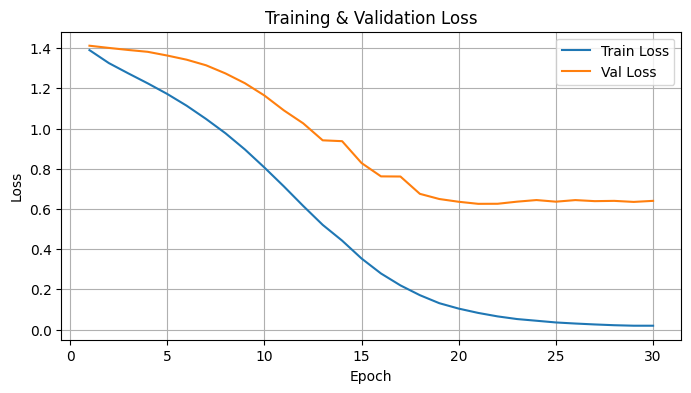

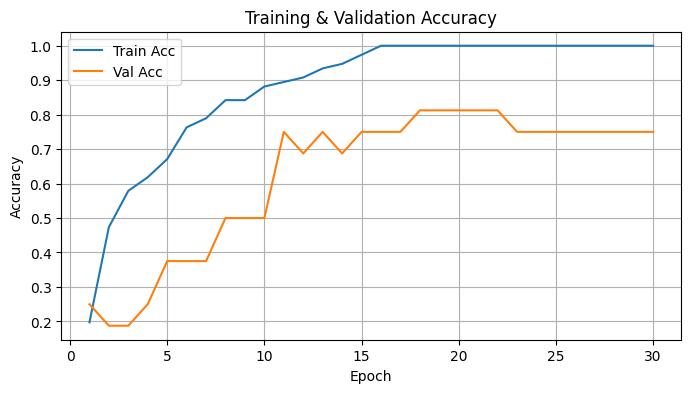

In [ ]:
# --- Plot training & validation curves ---
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs_range, history["train_loss"], label="Train Loss")
plt.plot(epochs_range, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs_range, history["train_acc"], label="Train Acc")
plt.plot(epochs_range, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## Grouped K-Fold Cross Validation

In [ ]:
# ===== Config =====
csv_path      = "eeg_bandpower_features_windowed_12.0_8.0.csv"
epochs        = 30
batch_size    = 16
hidden_dim    = 64
num_layers    = 1
dropout       = 0.1
lr            = 1e-3
n_folds       = 10
seed          = 0
bidirectional = True
force_cpu     = False
# ==================

# Reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() and not force_cpu else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# --- Load sequences/labels/subjects ---
sequences, labels, subjects, input_dim, num_classes, game_to_idx = build_sequences_from_csv(csv_path)

subjects = np.asarray(subjects)
labels   = np.asarray(labels)

n_groups = len(np.unique(subjects))
if n_folds > n_groups:
    raise ValueError(
        f"Requested {n_folds} folds but only {n_groups} unique SUBJECT groups. "
        f"Reduce n_folds or change grouping."
    )

print(f"Number of SUBJECT groups: {n_groups}")

# Group K-Fold by subject (keeps all windows for a subject together) ---
gkf = GroupKFold(n_splits=n_folds)
fold_splits = list(gkf.split(X=np.arange(len(labels)), y=labels, groups=subjects))

for i, (train_idx, val_idx) in enumerate(fold_splits):
    print(f"Fold {i}: train={len(train_idx)} sequences, val={len(val_idx)} sequences")

# --- Containers for overall CV metrics & history ---
cv_best_val_accs = []
cv_best_val_epochs = []

history_cv = {
    "train_loss": np.zeros(epochs, dtype=float),
    "train_acc":  np.zeros(epochs, dtype=float),
    "val_loss":   np.zeros(epochs, dtype=float),
    "val_acc":    np.zeros(epochs, dtype=float),
}

Found GAME labels: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
GAME -> class index map: {np.int64(1): 0, np.int64(2): 1, np.int64(3): 2, np.int64(4): 3}
Number of SUBJECT groups: 28
Fold 0: train=100 sequences, val=12 sequences
Fold 1: train=100 sequences, val=12 sequences
Fold 2: train=100 sequences, val=12 sequences
Fold 3: train=100 sequences, val=12 sequences
Fold 4: train=100 sequences, val=12 sequences
Fold 5: train=100 sequences, val=12 sequences
Fold 6: train=100 sequences, val=12 sequences
Fold 7: train=100 sequences, val=12 sequences
Fold 8: train=104 sequences, val=8 sequences
Fold 9: train=104 sequences, val=8 sequences


In [ ]:
# --- Grouped K-Fold CV Training ---
for fold_idx, (train_idx, val_idx) in enumerate(fold_splits):
    print("\n" + "=" * 60)
    print(f"Fold {fold_idx + 1}/{n_folds}")
    print("=" * 60)
    print(f"  Train sequences: {len(train_idx)} | Val sequences: {len(val_idx)}")

    # Normalize using only training sequences for this fold
    sequences_norm, mean, std = normalize_with_train_stats(sequences, train_idx)

    # Build datasets/loaders (each sequence already aggregates its windows)
    train_seqs   = [sequences_norm[i] for i in train_idx]
    train_labels = [int(labels[i]) for i in train_idx]

    val_seqs     = [sequences_norm[i] for i in val_idx]
    val_labels   = [int(labels[i]) for i in val_idx]

    train_dataset = EEGSequenceDataset(train_seqs, train_labels)
    val_dataset   = EEGSequenceDataset(val_seqs, val_labels)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn,
    )

    # New model for each fold
    model = LSTMEegClassifier(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        num_classes=num_classes,
        bidirectional=bidirectional,
        dropout=dropout,
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0
    best_epoch = 0

    # --- Training loop for this fold ---
    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc     = evaluate(model, val_loader, criterion, device)

        # accumulate for mean curves
        history_cv["train_loss"][epoch - 1] += train_loss
        history_cv["train_acc"][epoch - 1]  += train_acc
        history_cv["val_loss"][epoch - 1]   += val_loss
        history_cv["val_acc"][epoch - 1]    += val_acc

        print(
            f"Fold {fold_idx + 1} | Epoch {epoch:02d} | "
            f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
            f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}"
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch

    cv_best_val_accs.append(best_val_acc)
    cv_best_val_epochs.append(best_epoch)

# --- Average metrics across folds for curves ---
history_cv["train_loss"] /= n_folds
history_cv["train_acc"]  /= n_folds
history_cv["val_loss"]   /= n_folds
history_cv["val_acc"]    /= n_folds

mean_best_val = float(np.mean(cv_best_val_accs))
std_best_val  = float(np.std(cv_best_val_accs))


Fold 1/10
  Train sequences: 100 | Val sequences: 12
Fold 1 | Epoch 01 | train_loss=1.3692, train_acc=0.3200 | val_loss=1.3493, val_acc=0.1667
Fold 1 | Epoch 02 | train_loss=1.2849, train_acc=0.5100 | val_loss=1.3144, val_acc=0.3333
Fold 1 | Epoch 03 | train_loss=1.2235, train_acc=0.6100 | val_loss=1.2866, val_acc=0.3333
Fold 1 | Epoch 04 | train_loss=1.1587, train_acc=0.7600 | val_loss=1.2585, val_acc=0.5833
Fold 1 | Epoch 05 | train_loss=1.0866, train_acc=0.8400 | val_loss=1.2303, val_acc=0.5833
Fold 1 | Epoch 06 | train_loss=1.0050, train_acc=0.8400 | val_loss=1.1947, val_acc=0.6667
Fold 1 | Epoch 07 | train_loss=0.9126, train_acc=0.8700 | val_loss=1.1403, val_acc=0.5833
Fold 1 | Epoch 08 | train_loss=0.8155, train_acc=0.9000 | val_loss=1.0596, val_acc=0.7500
Fold 1 | Epoch 09 | train_loss=0.7046, train_acc=0.9300 | val_loss=0.9721, val_acc=0.7500
Fold 1 | Epoch 10 | train_loss=0.5824, train_acc=0.9600 | val_loss=0.8388, val_acc=0.7500
Fold 1 | Epoch 11 | train_loss=0.4660, train_a


--- Per-Fold Accuracy for LSTM (LSTMEegClassifier) ---
Fold 1: 1.0000  (best epoch: 14)
Fold 2: 1.0000  (best epoch: 13)
Fold 3: 0.9167  (best epoch: 17)
Fold 4: 1.0000  (best epoch: 18)
Fold 5: 1.0000  (best epoch: 18)
Fold 6: 1.0000  (best epoch: 13)
Fold 7: 0.9167  (best epoch: 10)
Fold 8: 1.0000  (best epoch: 9)
Fold 9: 1.0000  (best epoch: 13)
Fold 10: 1.0000  (best epoch: 15)
------------------------------------------------------------
Mean Accuracy: 0.9833 (±0.0333)
------------------------------------------------------------
## 📊 Summary of Multi-class Classification Results
---
    Classifier            Mean Accuracy
0   LSTM                       0.983333


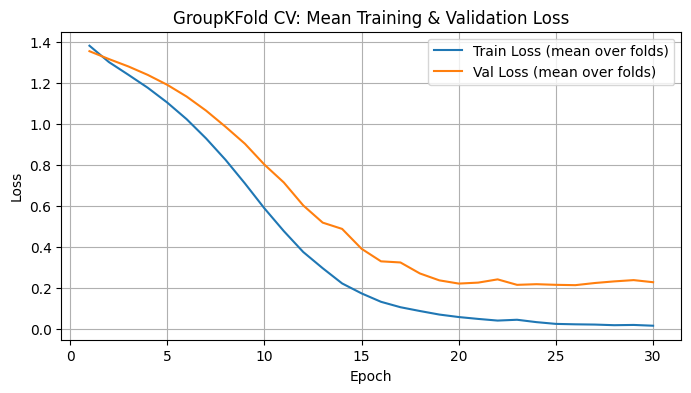

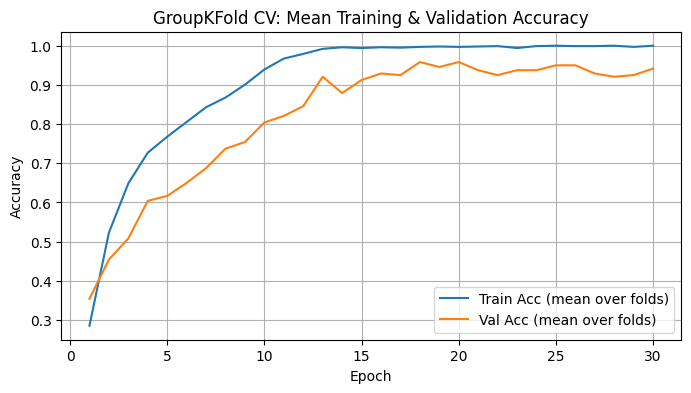

In [ ]:
# --- Report per-fold & mean accuracy summary
print("\n--- Per-Fold Accuracy for LSTM (LSTMEegClassifier) ---")
for i, (acc, ep) in enumerate(zip(cv_best_val_accs, cv_best_val_epochs), start=1):
    print(f"Fold {i}: {acc:.4f}  (best epoch: {ep})")
print("-" * 60)
print(f"Mean Accuracy: {mean_best_val:.4f} (±{std_best_val:.4f})")
print("-" * 60)
print("## 📊 Summary of Multi-class Classification Results")
print("---")
print(f"{'':<3} {'Classifier':<20} {'Mean Accuracy':>14}")
print(f"{0:<3} {'LSTM':<20} {mean_best_val:>14.6f}")

# --- Plot averaged training & validation curves ---
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs_range, history_cv["train_loss"], label="Train Loss (mean over folds)")
plt.plot(epochs_range, history_cv["val_loss"], label="Val Loss (mean over folds)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GroupKFold CV: Mean Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(epochs_range, history_cv["train_acc"], label="Train Acc (mean over folds)")
plt.plot(epochs_range, history_cv["val_acc"], label="Val Acc (mean over folds)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("GroupKFold CV: Mean Training & Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()